In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
from os import path
import math
import time
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import optimize
from utils import *

In [2]:
from sklearn.mixture import GaussianMixture

In [3]:
py4DSTEM.__version__

'0.12.6'

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [8.0, 6.0]

## Data Loading

In [5]:
#import and read data
file_folder = "./data/"
file_name = "example_1.dm4"
filepath_input = file_folder+file_name
datacube = py4DSTEM.io.read(filepath_input)

## Particle Identification

In [6]:
#look at data without margin area
datacube_origin = datacube.data[8:-8, 8:-8,:,:]

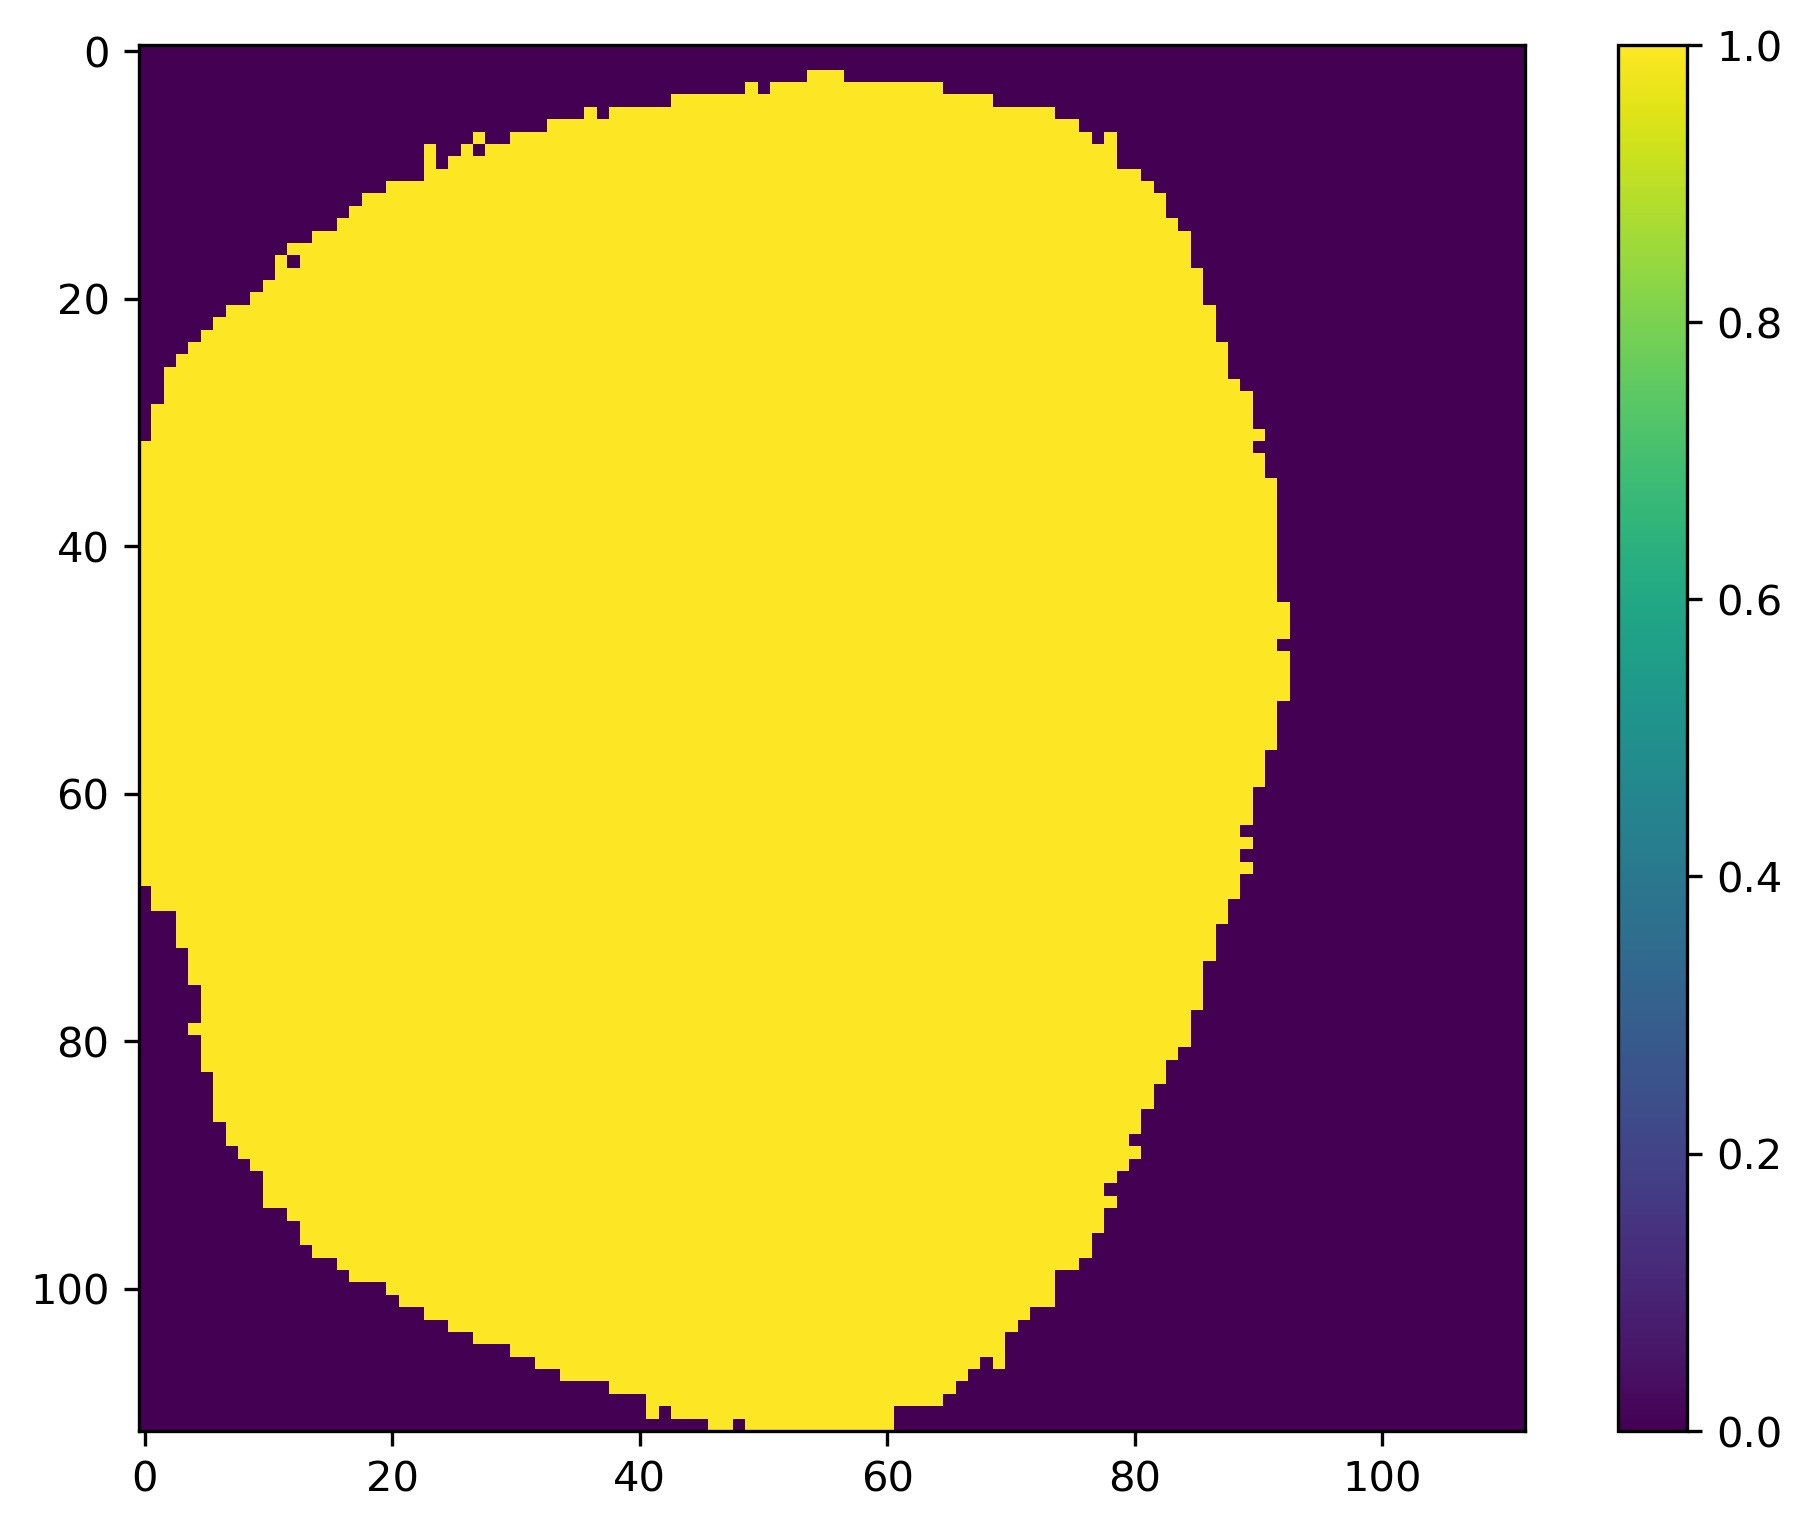

In [7]:
#threshold pixel values to indicate if a pixel belongs to particle area or not
particle_labels = IsParticle(datacube_origin, thres=60000)
plt.imshow(particle_labels);plt.colorbar()

## Average, symmetrization

In [8]:
#datacube_average: after spatially smoothing
#datacube_info: stores average info separately for display
#py4DSTEM function modifies the data in place
#so always keep storage separately if there is display needs in the future
datacube_average, datacube_info = average_datacube(datacube, n=8)

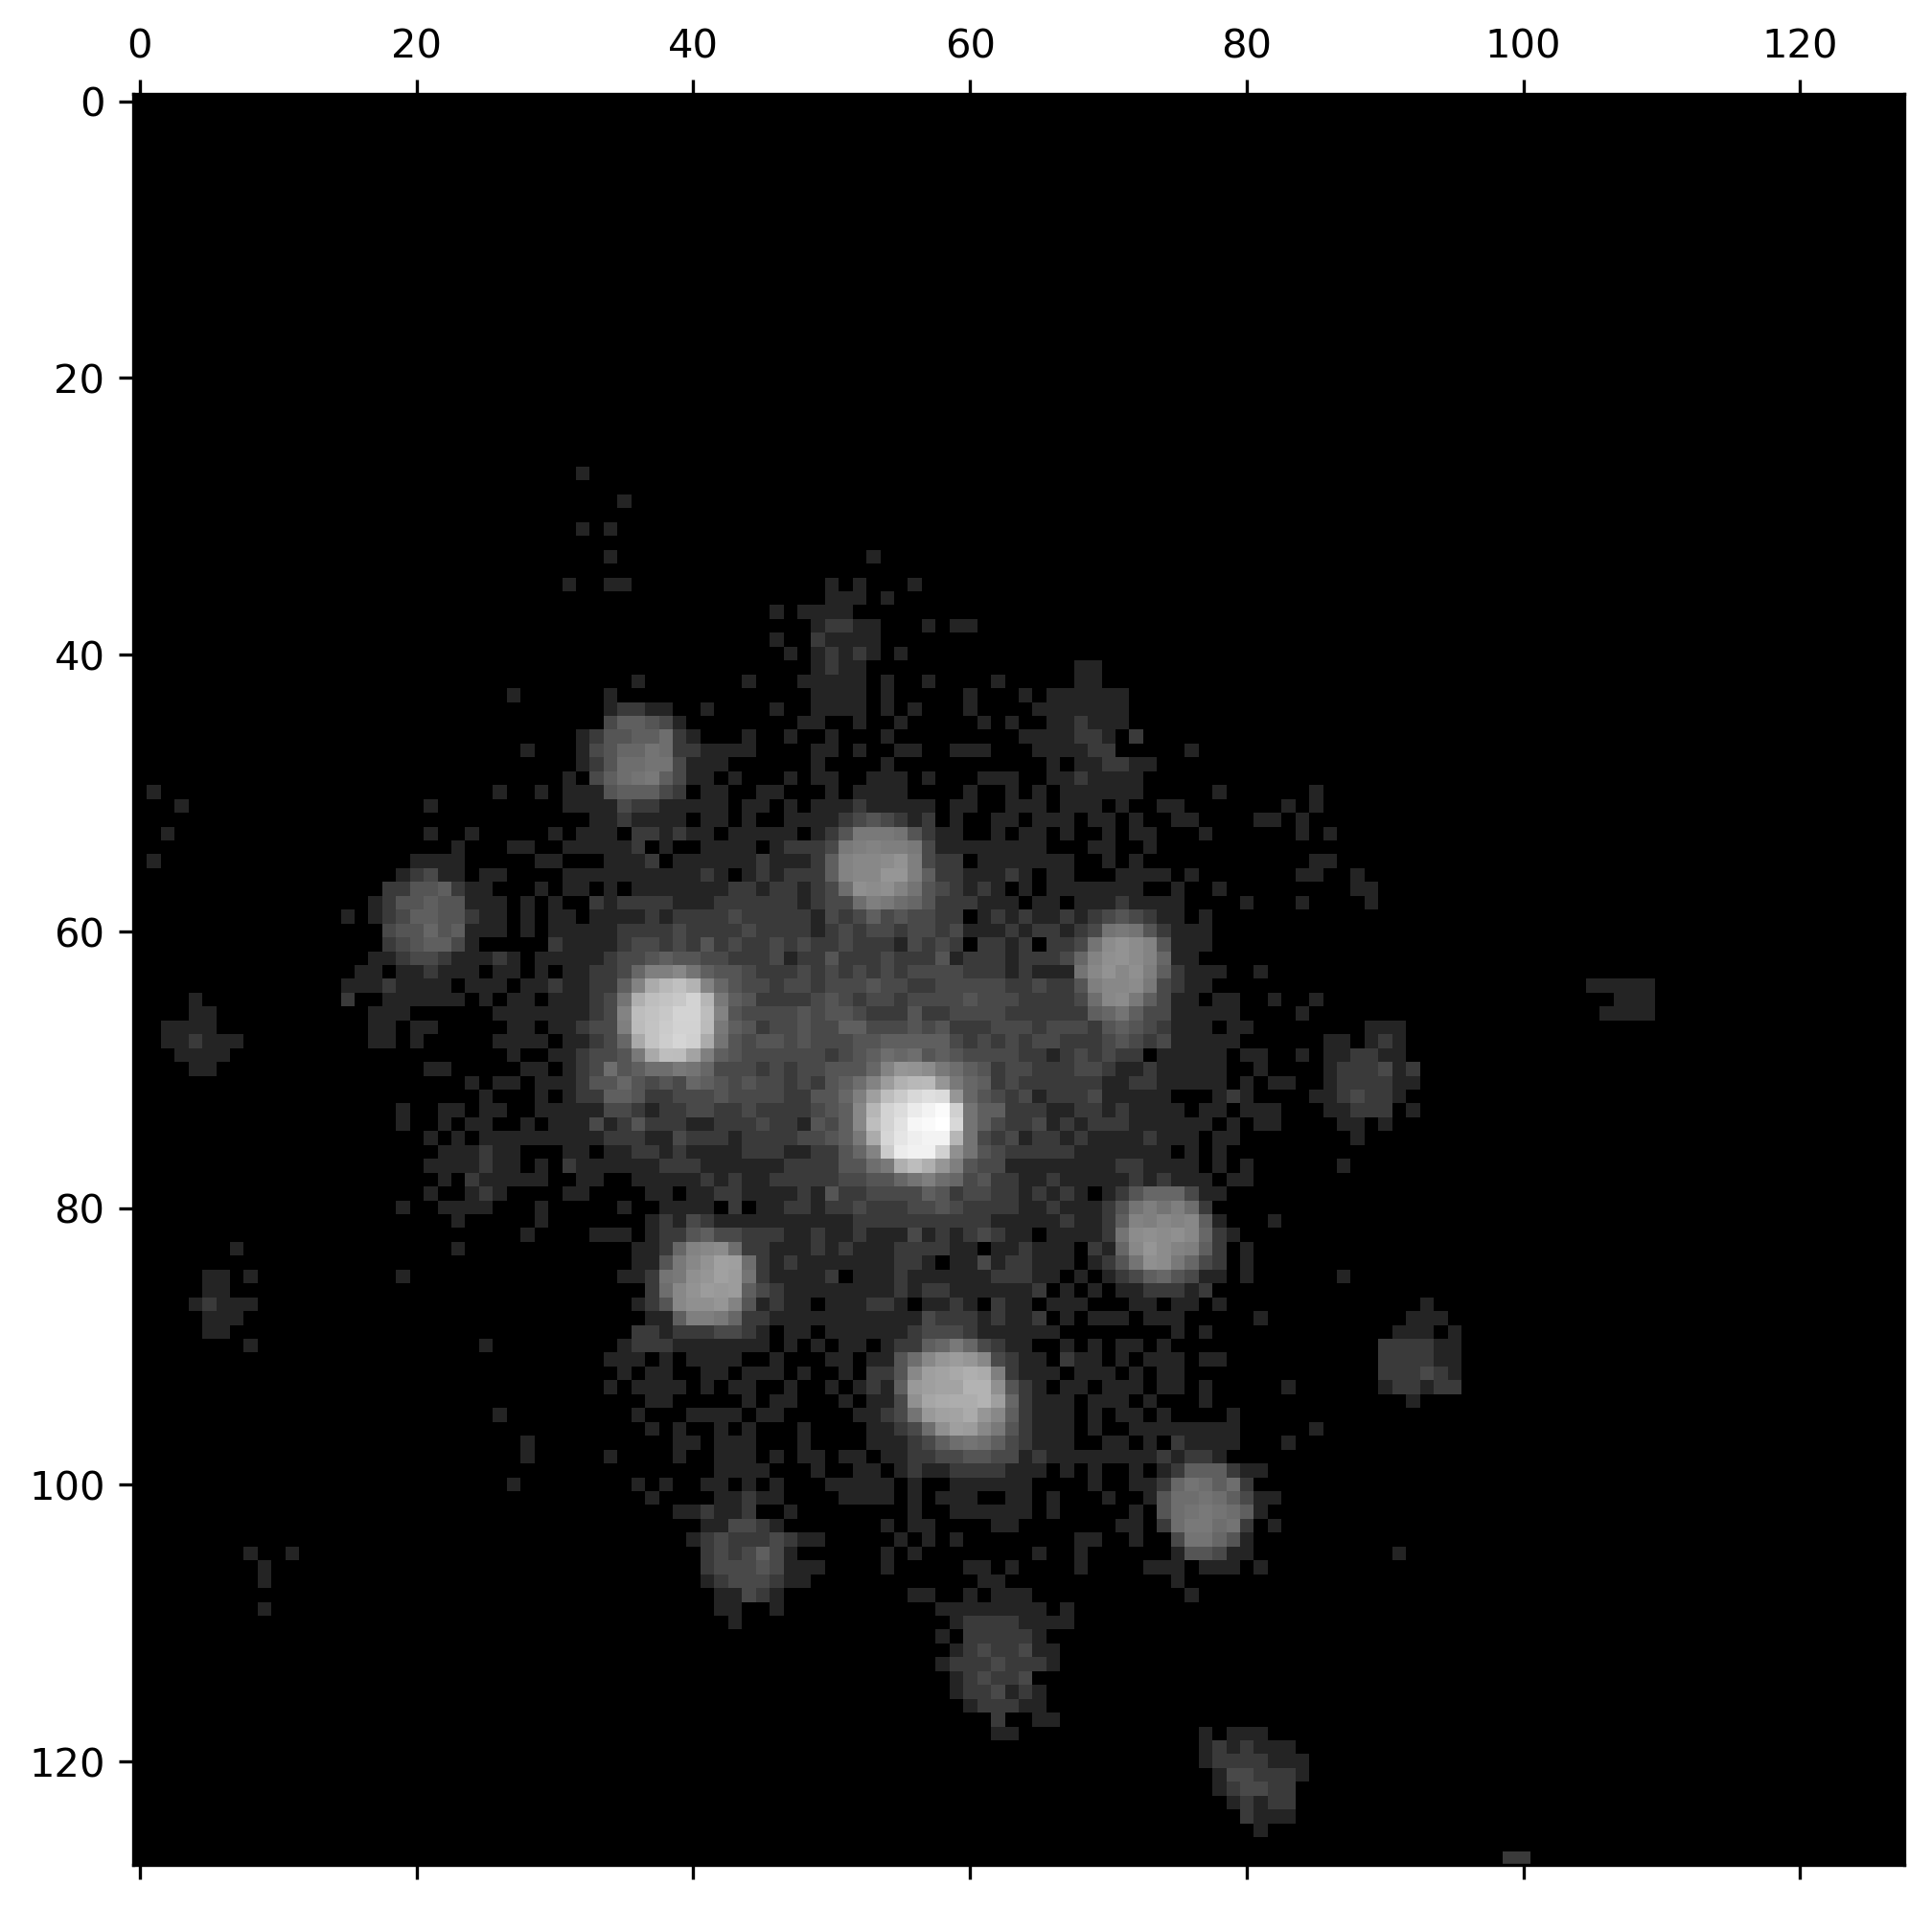

In [9]:
#display the DP at real space with coordinates [100, 40] after log-transformation
py4DSTEM.visualize.show(datacube_info[100][40], scaling='log')

In [10]:
#obtain the probe (kernel)
#use py4dstem functions
#obtain the center coordinates and assign to origin_x, origin_y
probe = py4DSTEM.process.diskdetection.get_probe_from_vacuum_4Dscan(datacube, mask_threshold=0.002, verbose = False)
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_gaussian(probe, sigma_probe_scale=2)
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel))
n = np.argmax(probe.flatten())
origin_x, origin_y = np.unravel_index(n, datacube_average.data.shape[2:])

100%|████████████████████████████████████| 12543/12543 [00:36<00:00, 340.38it/s]


In [11]:
#symmetrize the data
datacube_symmetrize, datacube_info_s = symmetrize_datacube(datacube_average, probe_kernel_FT, origin_x=origin_x, origin_y=origin_y)

100%|█████████████████████████████████████| 12544/12544 [04:24<00:00, 47.39it/s]


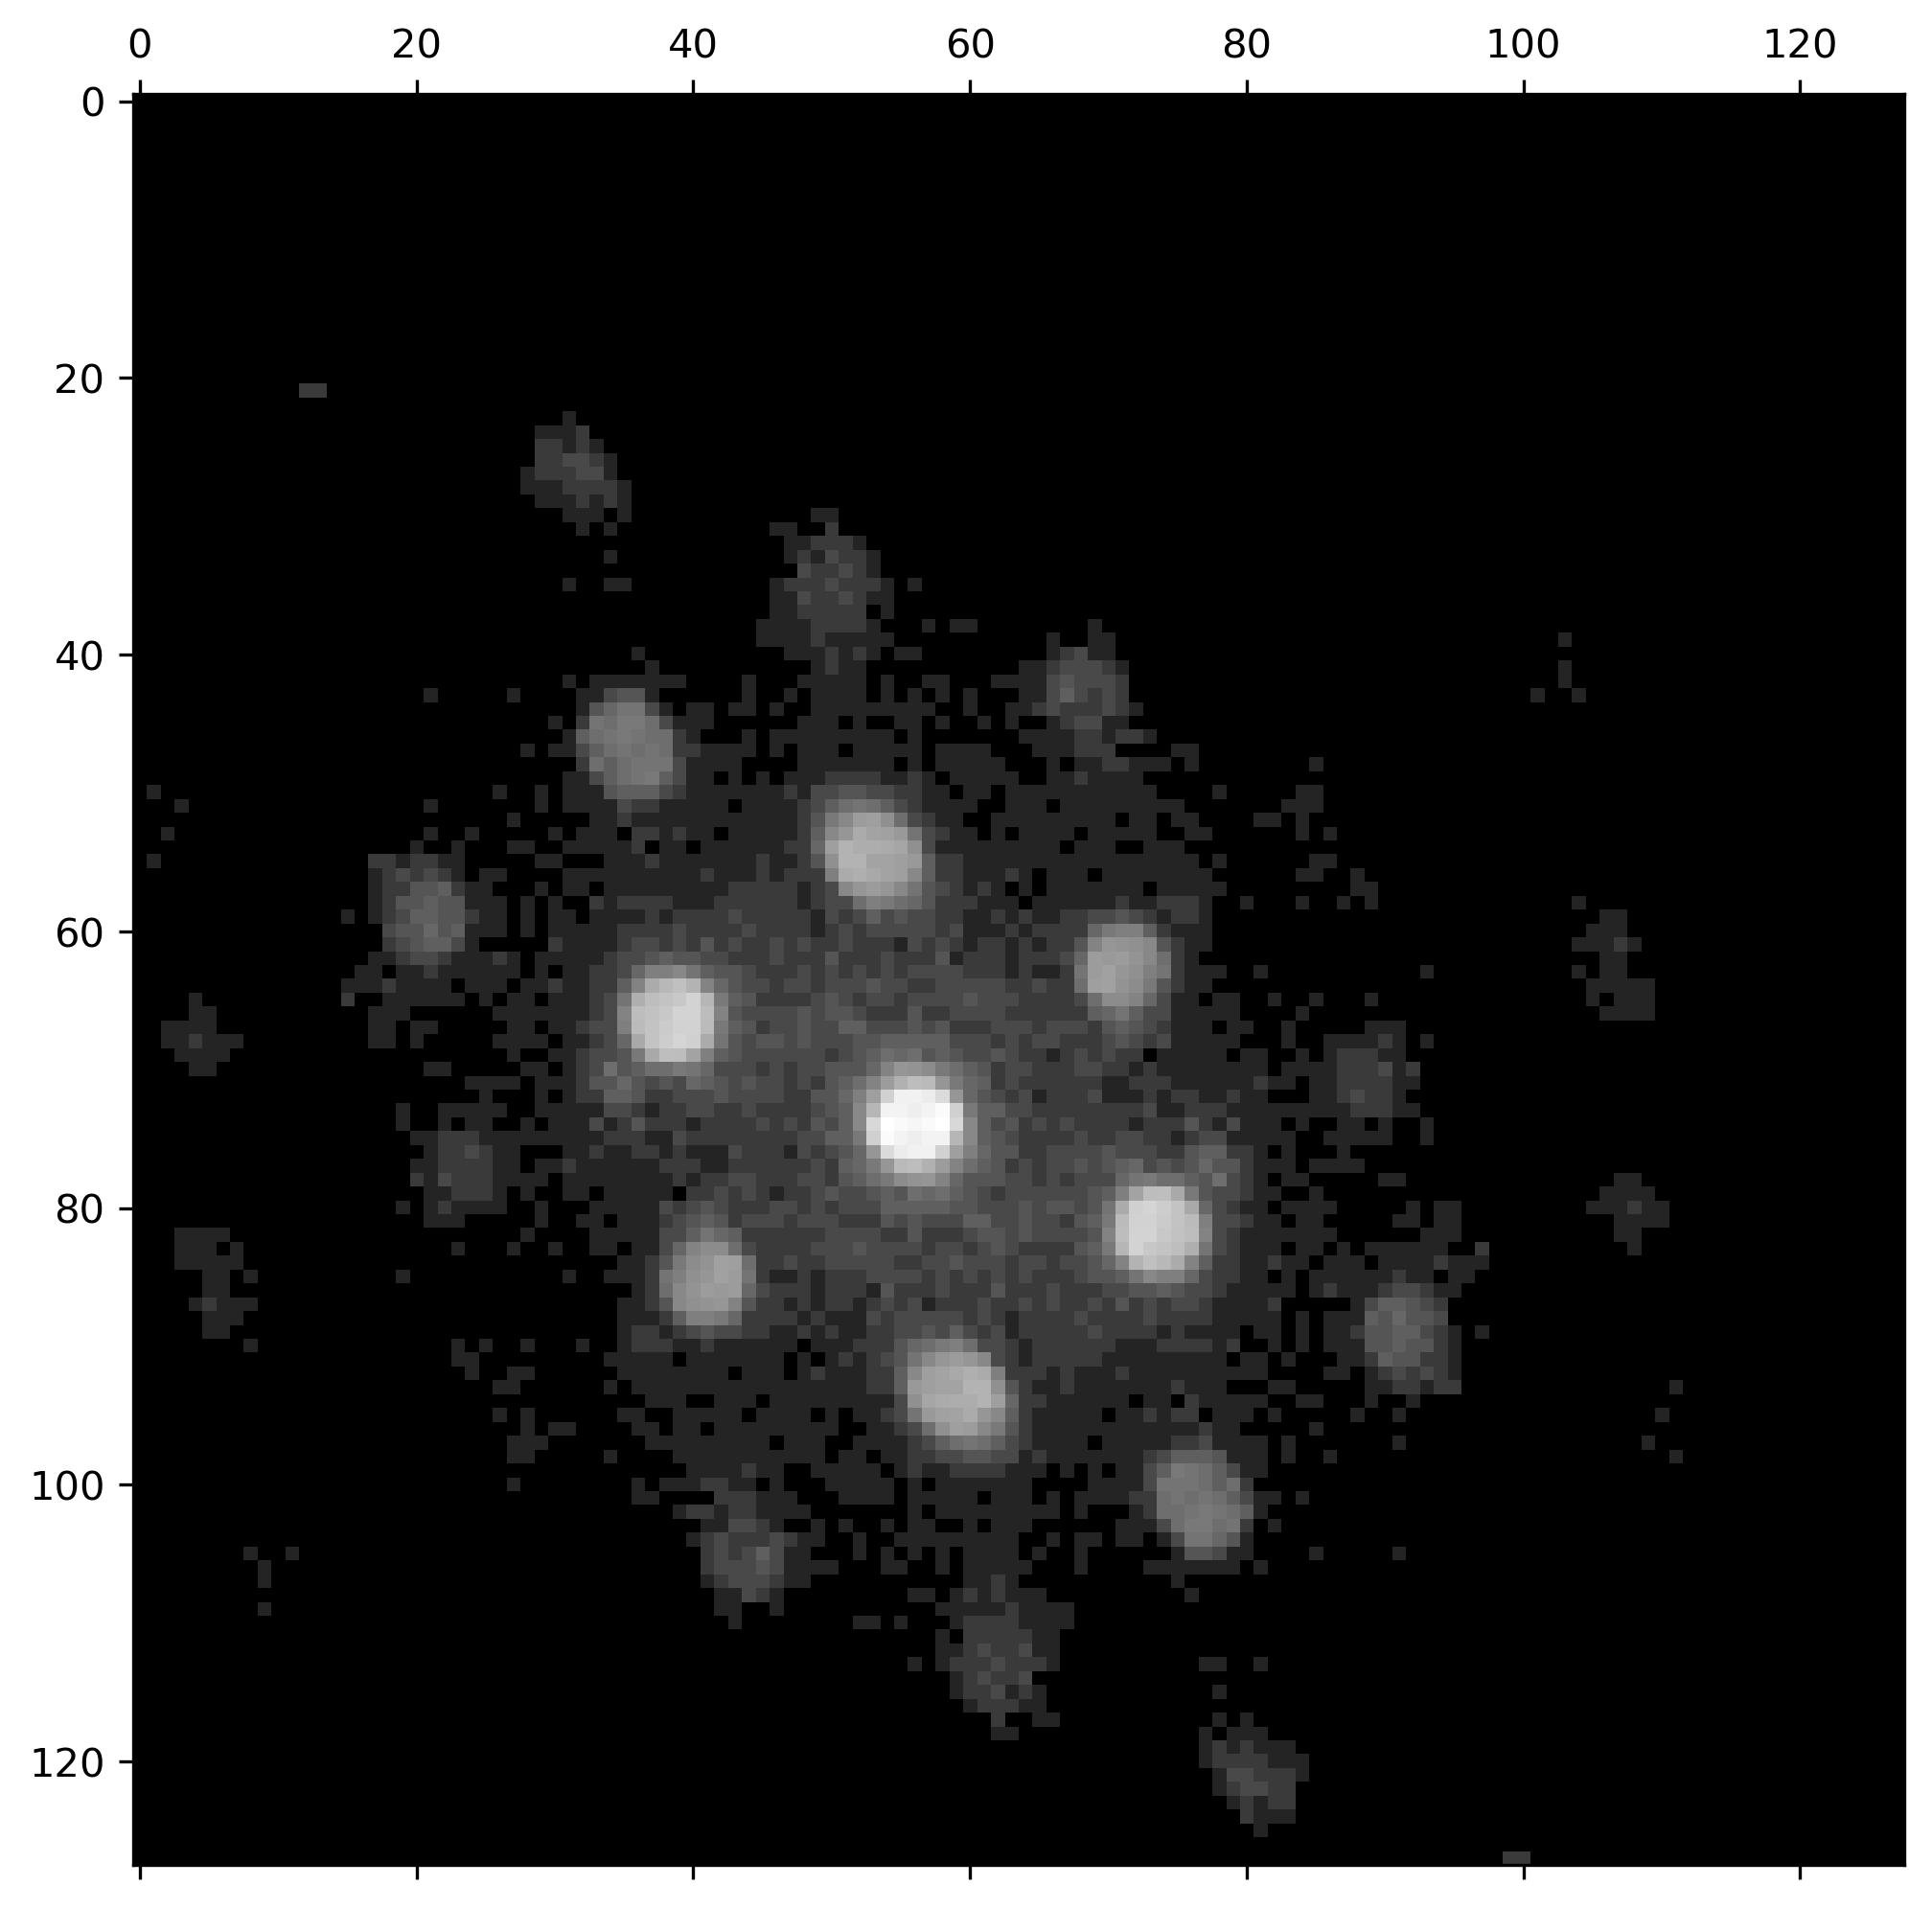

In [12]:
Rx, Ry = 100,40
py4DSTEM.visualize.show(datacube_symmetrize.data[Rx][Ry],scaling='log')

## Background Subtraction

In [14]:
particle_index, nonparticle_index, particle_count = generate_particle_index(datacube_symmetrize, particle_labels)

100%|█████████████████████████████████| 12544/12544 [00:00<00:00, 164747.24it/s]


In [15]:
#obtain the amplitude parameters from pixels in the background region
alpha_bg = bg_param(datacube_symmetrize, nonparticle_index, origin_x, origin_y)

100%|███████████████████████████████████████| 4414/4414 [00:47<00:00, 93.21it/s]


In [16]:
#obtain the estimated parameters of the function fitted to the integrated annular curve
#for all pixels that belong to the particle area
par_param = particle_param(datacube_symmetrize, particle_index, alpha_bg, origin_x, origin_y)

100%|███████████████████████████████████████| 8130/8130 [01:45<00:00, 76.97it/s]


In [17]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 300

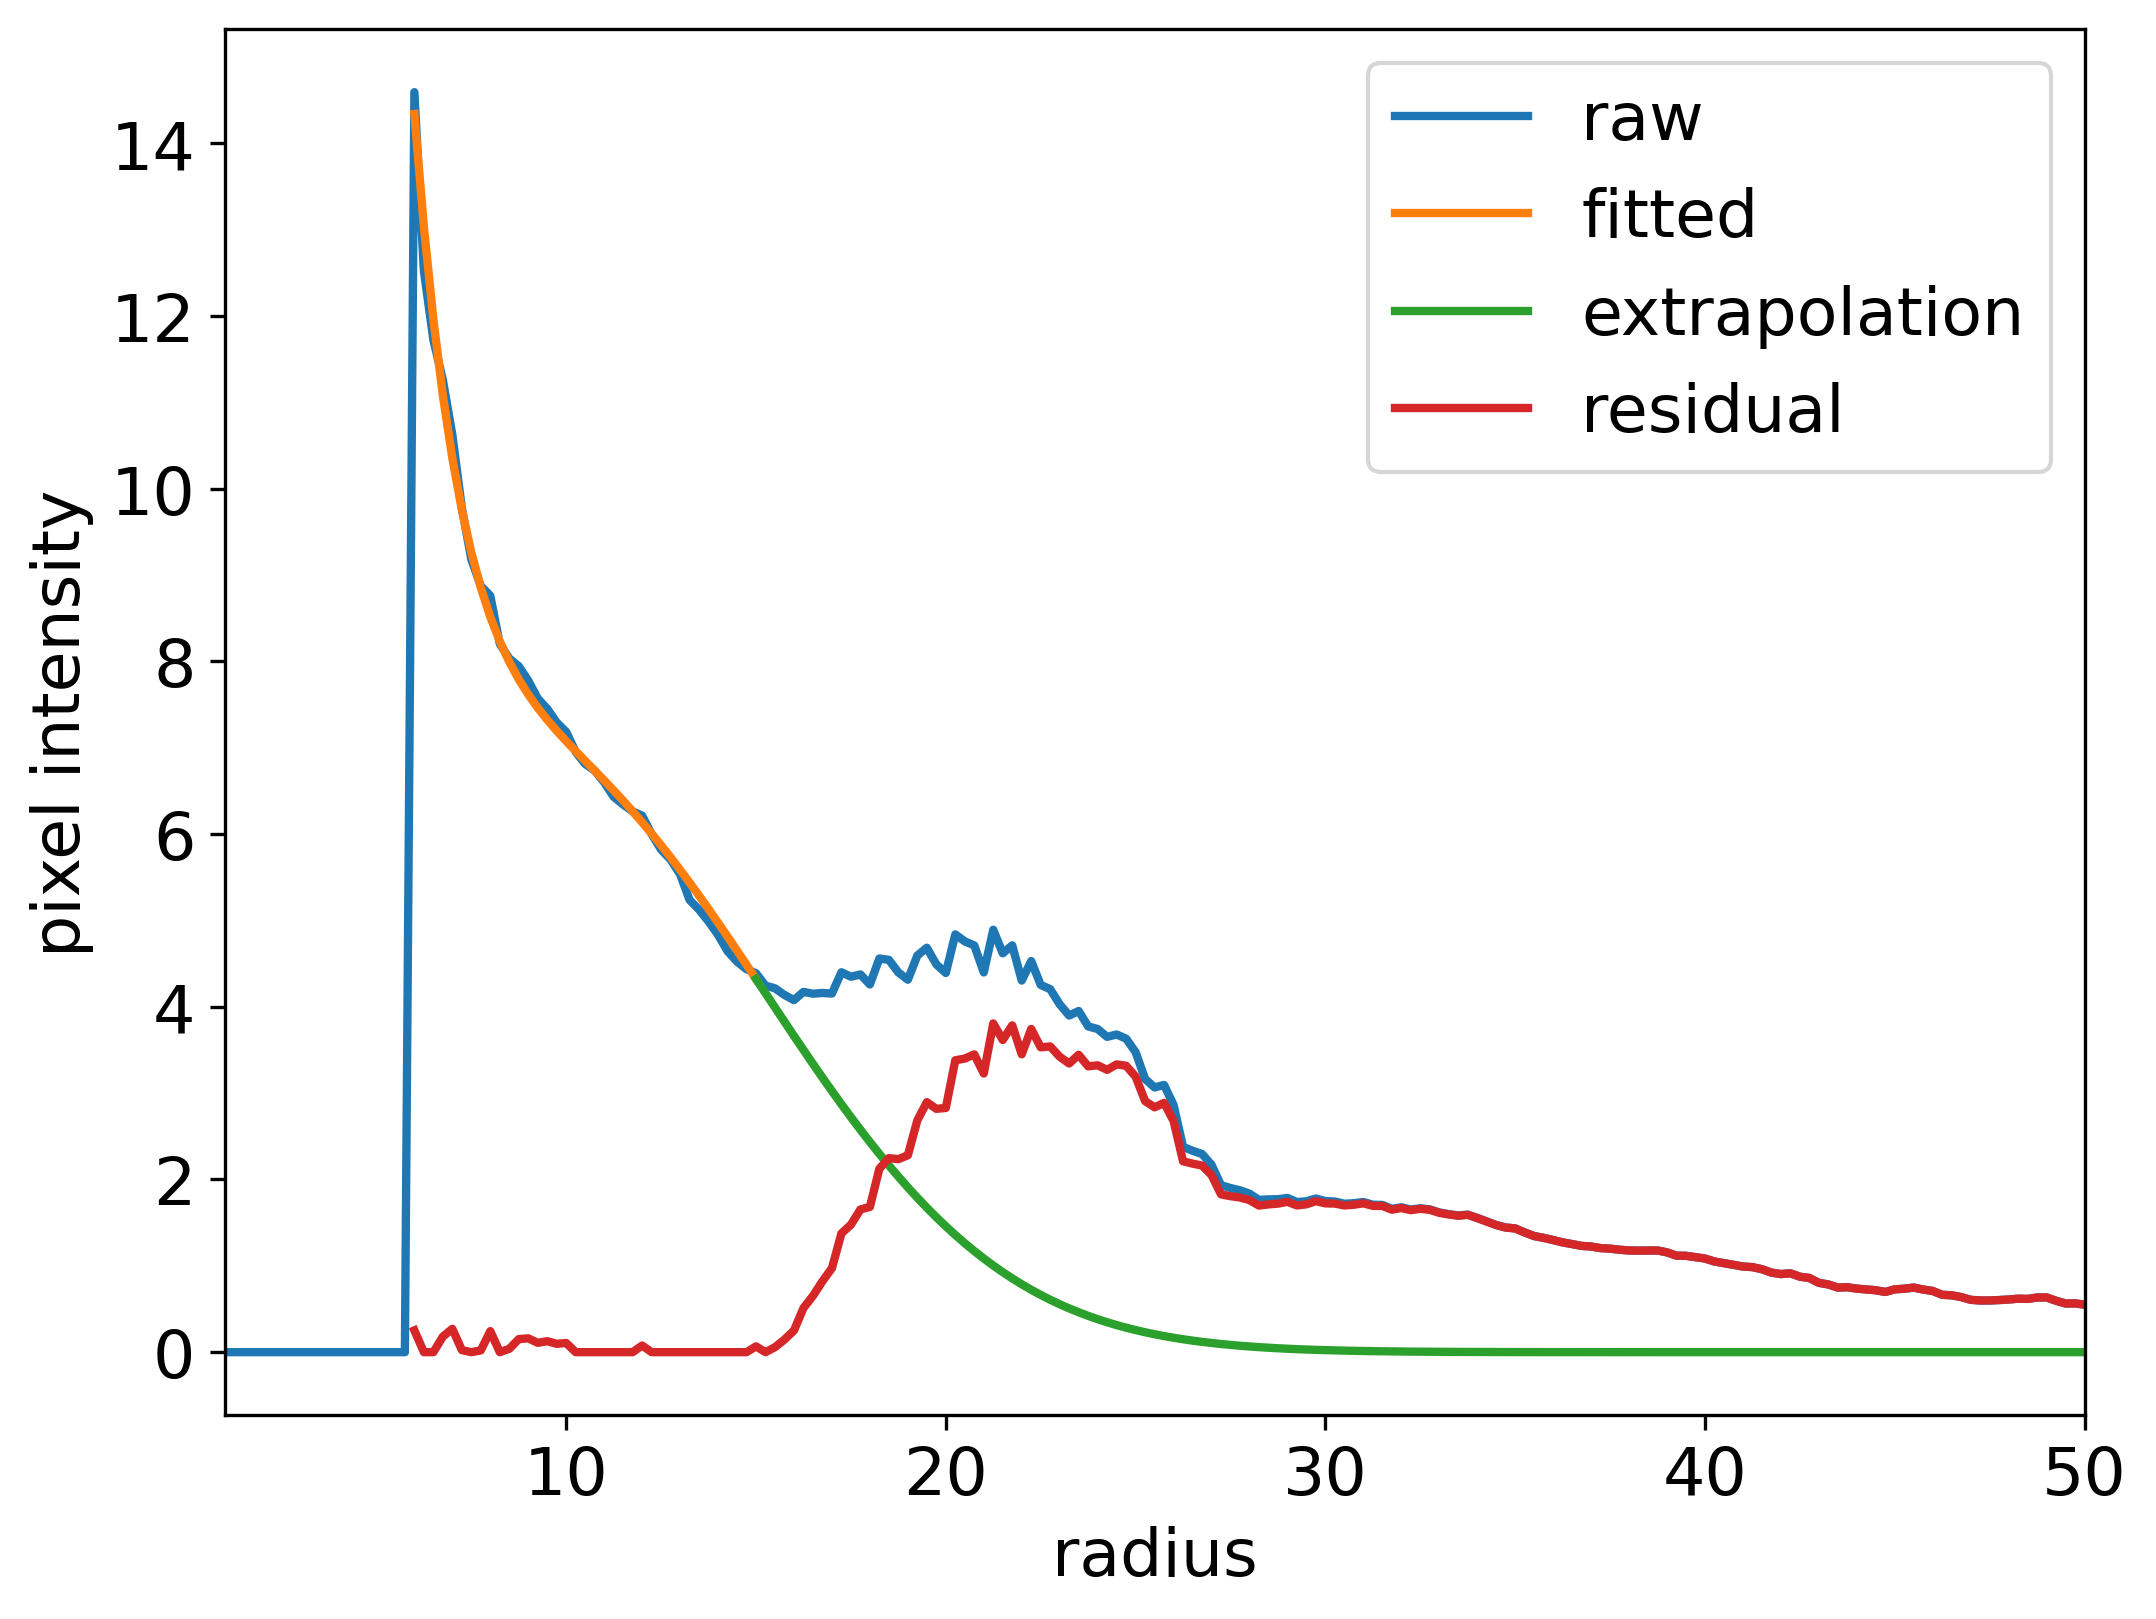

In [18]:
#look at fitted curve for pixle [60,85]
particle_curve(datacube_symmetrize, datacube_info_s, Rx=60, Ry=85, particle_index=particle_index, par_para=par_param, alpha_bg=alpha_bg, origin_x=origin_x, origin_y=origin_y)

In [19]:
#subtract the background from symmetrized DPs
center = [origin_x, origin_y]
datacube_symmetrize = subtract_bg(datacube_symmetrize, particle_index, par_param, center, alpha_bg)

100%|███████████████████████████████████████| 8130/8130 [10:31<00:00, 12.87it/s]


# Bragg disk detection

In [20]:
#pre-specify some parameters for later function usage
corrPower=1
sigma=1
edgeBoundary=2
minRelativeIntensity=0.0001
relativeToPeak=0
minPeakSpacing=1
minAbsoluteIntensity = 0.3
maxNumPeaks=100
subpixel='poly'
upsample_factor=16

In [21]:
# Get disks of all DPs
braggpeaks_raw = py4DSTEM.process.diskdetection.find_Bragg_disks(
                                datacube=datacube_symmetrize,
                                probe=probe_kernel,
                                corrPower=corrPower,
                                sigma=sigma,
                                edgeBoundary=edgeBoundary,
                                minRelativeIntensity=minRelativeIntensity,
                                relativeToPeak=relativeToPeak,
                                minPeakSpacing=minPeakSpacing,
                                minAbsoluteIntensity=minAbsoluteIntensity,
                                maxNumPeaks=maxNumPeaks,
                                subpixel=subpixel,
                                upsample_factor=upsample_factor
)

Finding Bragg Disks: 100%|██████████████████| 12.5k/12.5k [00:34<00:00, 367DP/s]


In [22]:
# delete the local maxima points that are within the center point neighborhood
for n in py4DSTEM.process.utils.tqdmnd(range(datacube_symmetrize.R_N)):
    Rx, Ry = np.unravel_index(n, datacube_symmetrize.data.shape[:2])
    #print(n)
    braggpeaks = braggpeaks_raw.pointlists[Rx][Ry].data
    index = [i for i in range(braggpeaks.shape[0]) if math.sqrt((braggpeaks[i][0]-origin_x)**2+(braggpeaks[i][1] - origin_y)**2)<10]
    braggpeaks_raw.pointlists[Rx][Ry].data = np.delete(braggpeaks, index)

100%|██████████████████████████████████| 12544/12544 [00:00<00:00, 27925.00it/s]


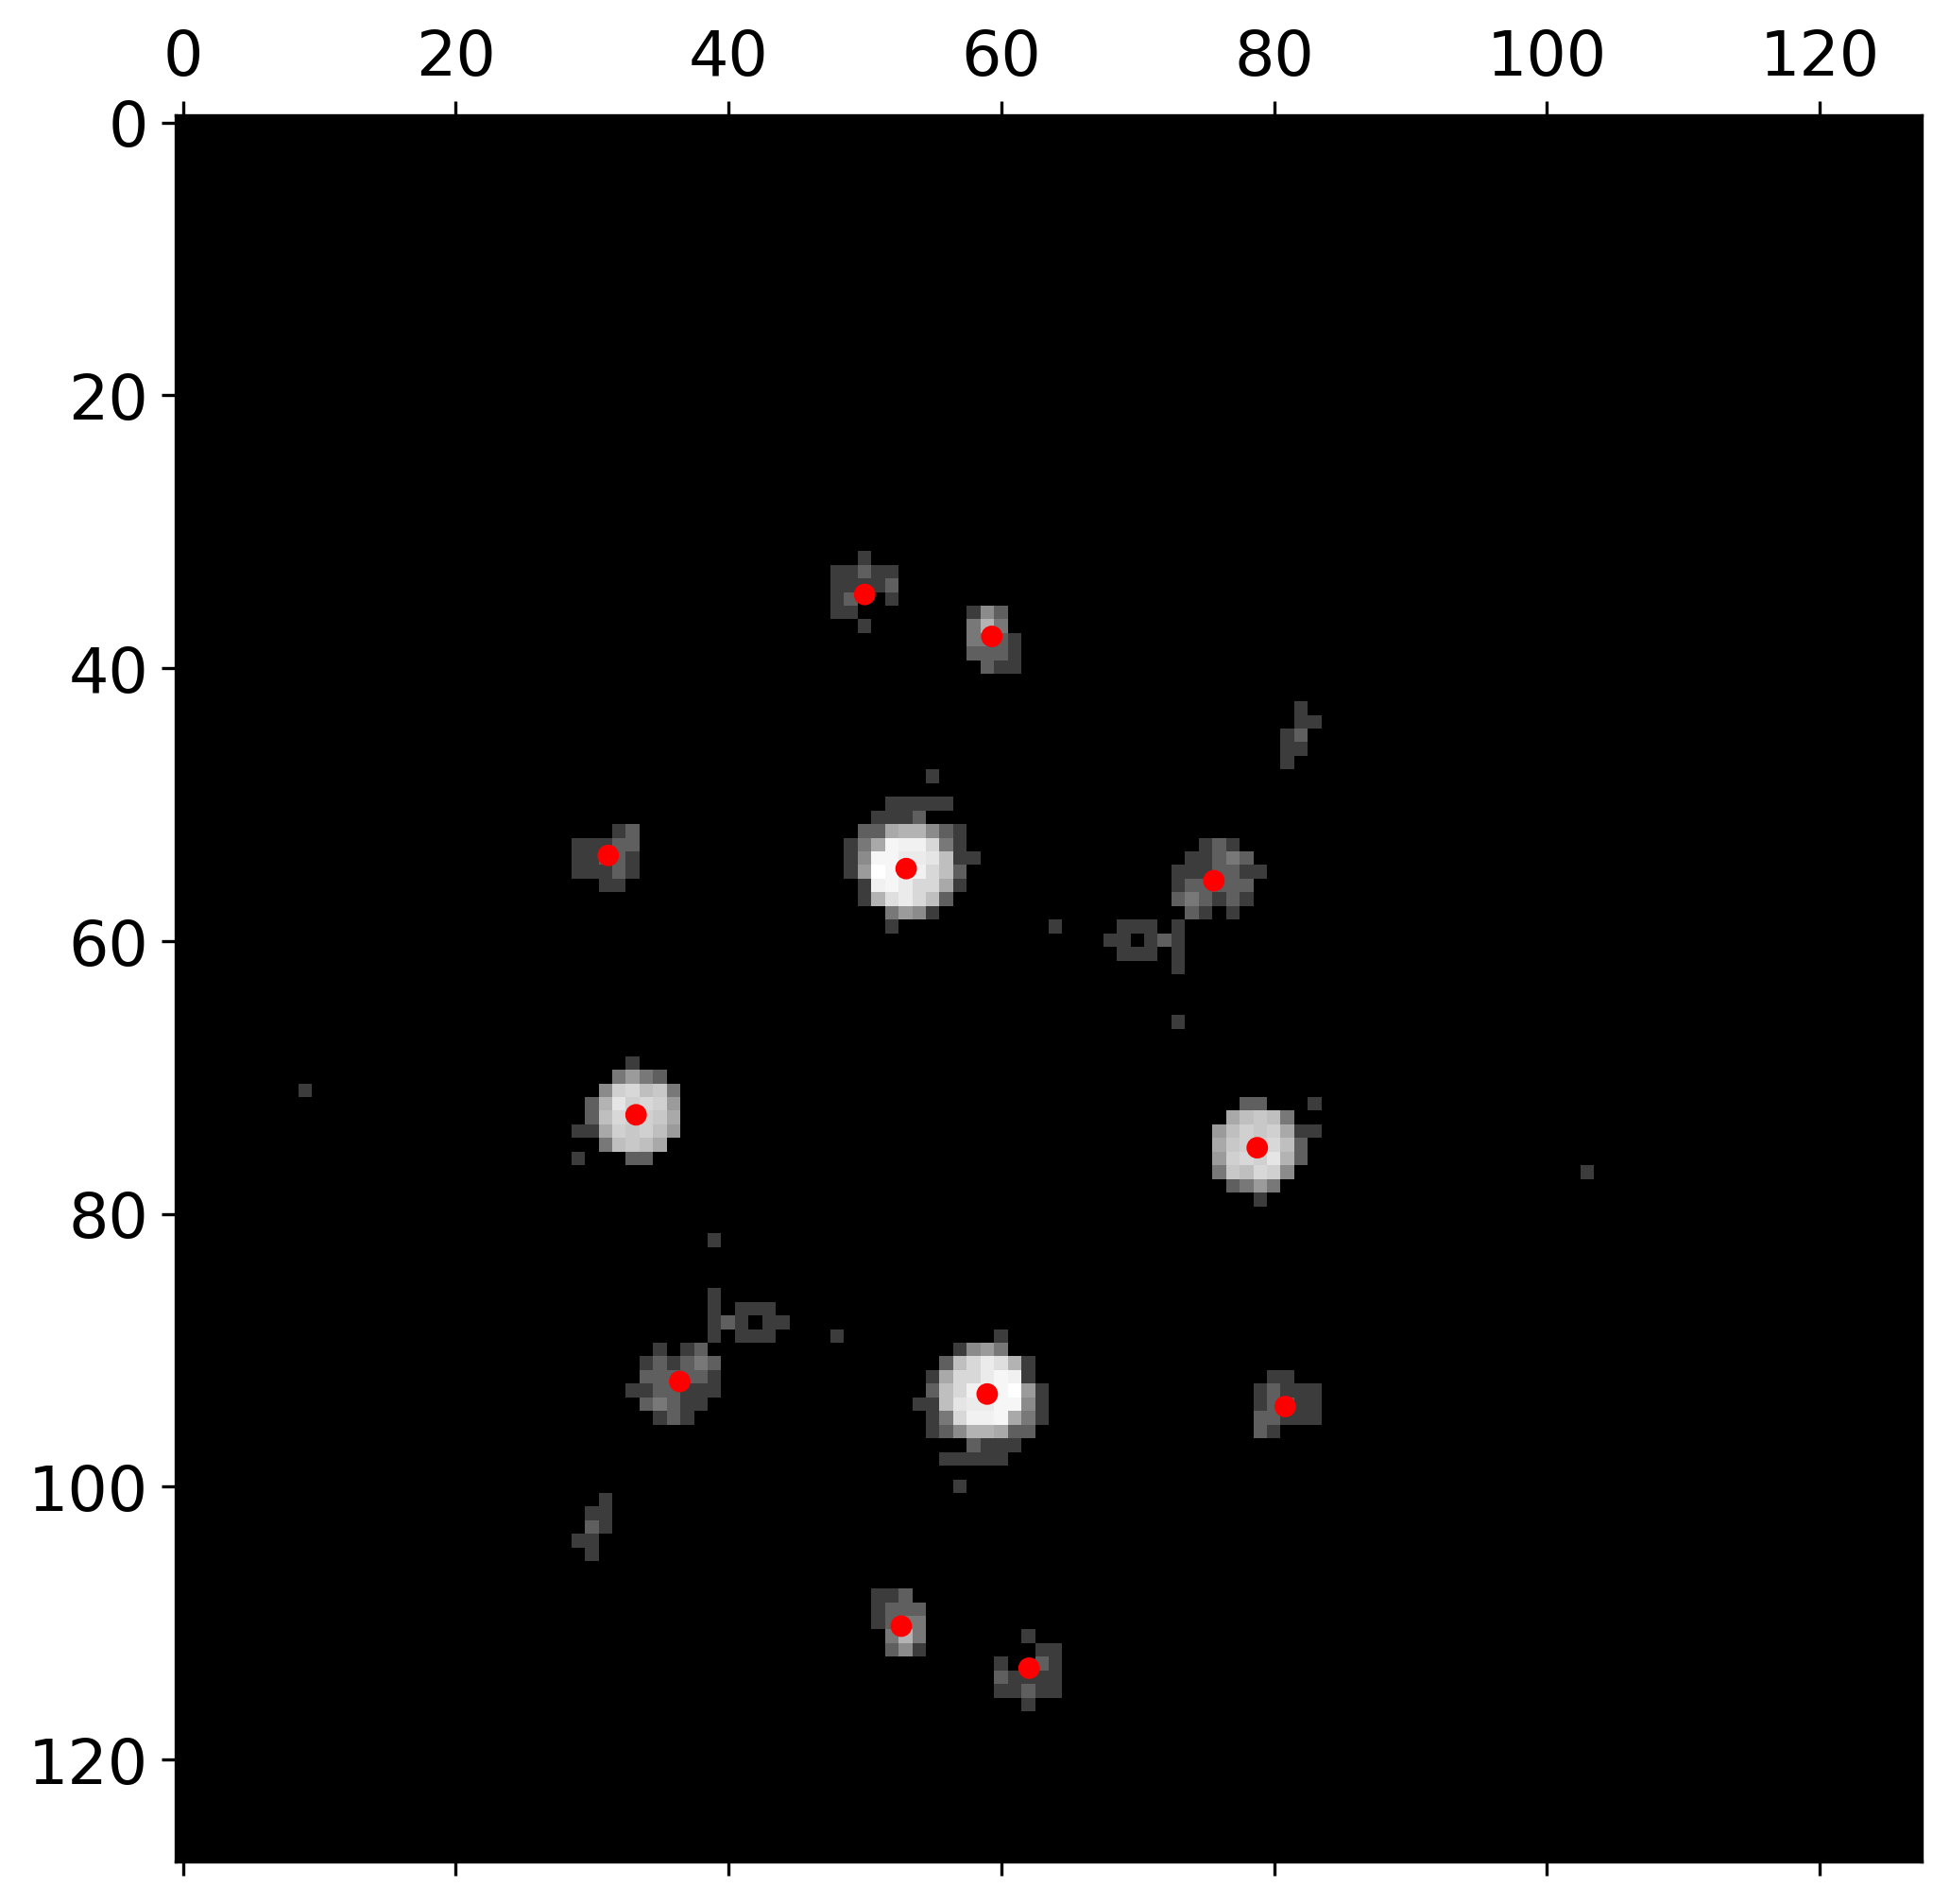

In [23]:
#display the bragg disk detection of pixel [50,60]
Rx, Ry = 50,60
corrPower=1
sigma=1
edgeBoundary=2
minRelativeIntensity=0.0001
relativeToPeak=0
minPeakSpacing=1
minAbsoluteIntensity = 0.3
maxNumPeaks=100
subpixel='poly'
upsample_factor=16
disks_selected=py4DSTEM.process.diskdetection.find_Bragg_disks_single_DP(datacube_symmetrize.data[Rx,Ry],probe_kernel,corrPower=corrPower,sigma=sigma,
                                                                       edgeBoundary=edgeBoundary,minRelativeIntensity=minRelativeIntensity,
                                                                       relativeToPeak=relativeToPeak,minPeakSpacing=minPeakSpacing,
                                                                       minAbsoluteIntensity=minAbsoluteIntensity,maxNumPeaks=maxNumPeaks,
                                                                       subpixel=subpixel,upsample_factor=upsample_factor)
#py4DSTEM.visualize.show_points(datacube_symmetrize.data[Rx][Ry], disks_selected.data['qx'], disks_selected.data['qy'],s=1,scale=20,alpha=1,pointcolor='r',scaling='log')
#py4DSTEM.visualize.show_points(datacube_info[Rx][Ry], disks_selected.data['qx'], disks_selected.data['qy'],s=1,scale=20,alpha=1,pointcolor='r',scaling='log')
py4DSTEM.visualize.show_points(datacube_symmetrize.data[Rx][Ry], braggpeaks_raw.pointlists[Rx][Ry].data['qx'], braggpeaks_raw.pointlists[Rx][Ry].data['qy'],s=1,scale=20,alpha=1,pointcolor='r',scaling='log')

# Obtain the Bragg vector map (BVM)

In [24]:
bvm_raw = get_bragg_vector_map_raw(braggpeaks_raw,datacube.Q_Nx,datacube.Q_Ny)

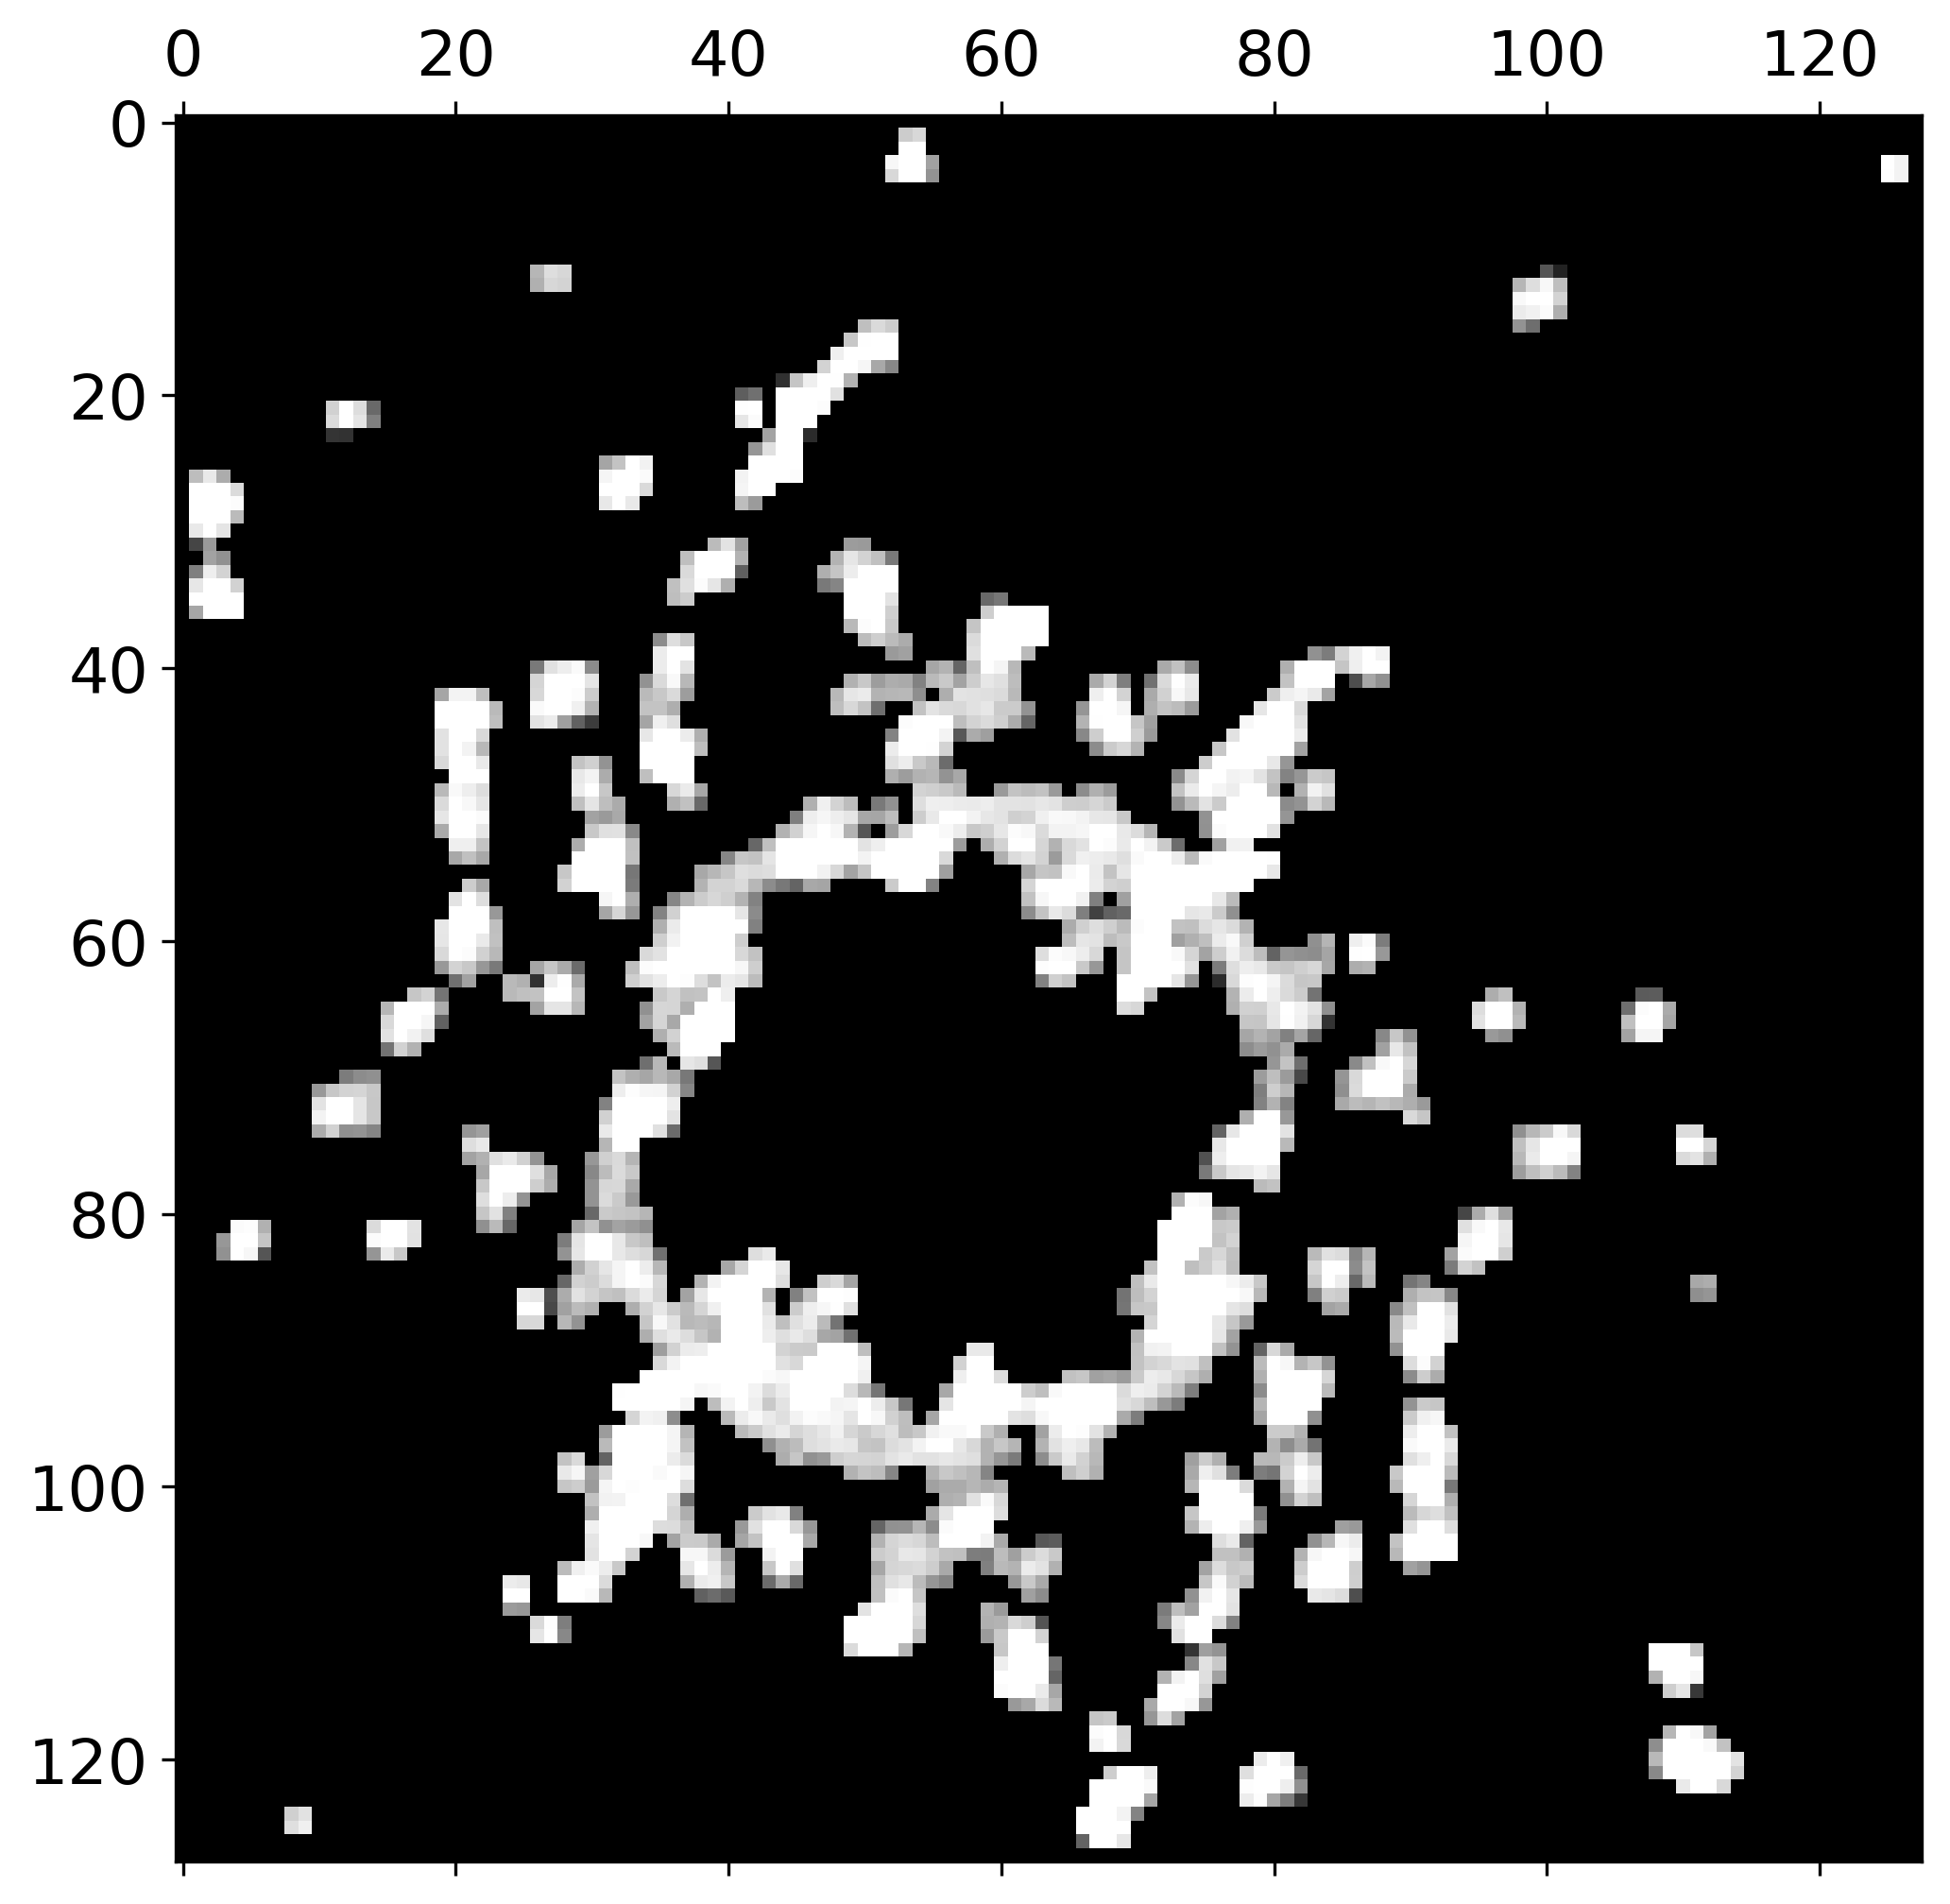

In [25]:
py4DSTEM.visualize.show(bvm_raw,cmap='gray',scaling='log',clipvals='manual',min=0,max=12)

In [26]:
#Obtain local maximum points from bragg vector map
gx,gy,gI = py4DSTEM.process.utils.get_maxima_2D(
                bvm_raw,
                edgeBoundary=1,
                minSpacing=0,
                minRelativeIntensity=0.001,
                relativeToPeak=0,
                maxNumPeaks=60,
                subpixel='none'
)

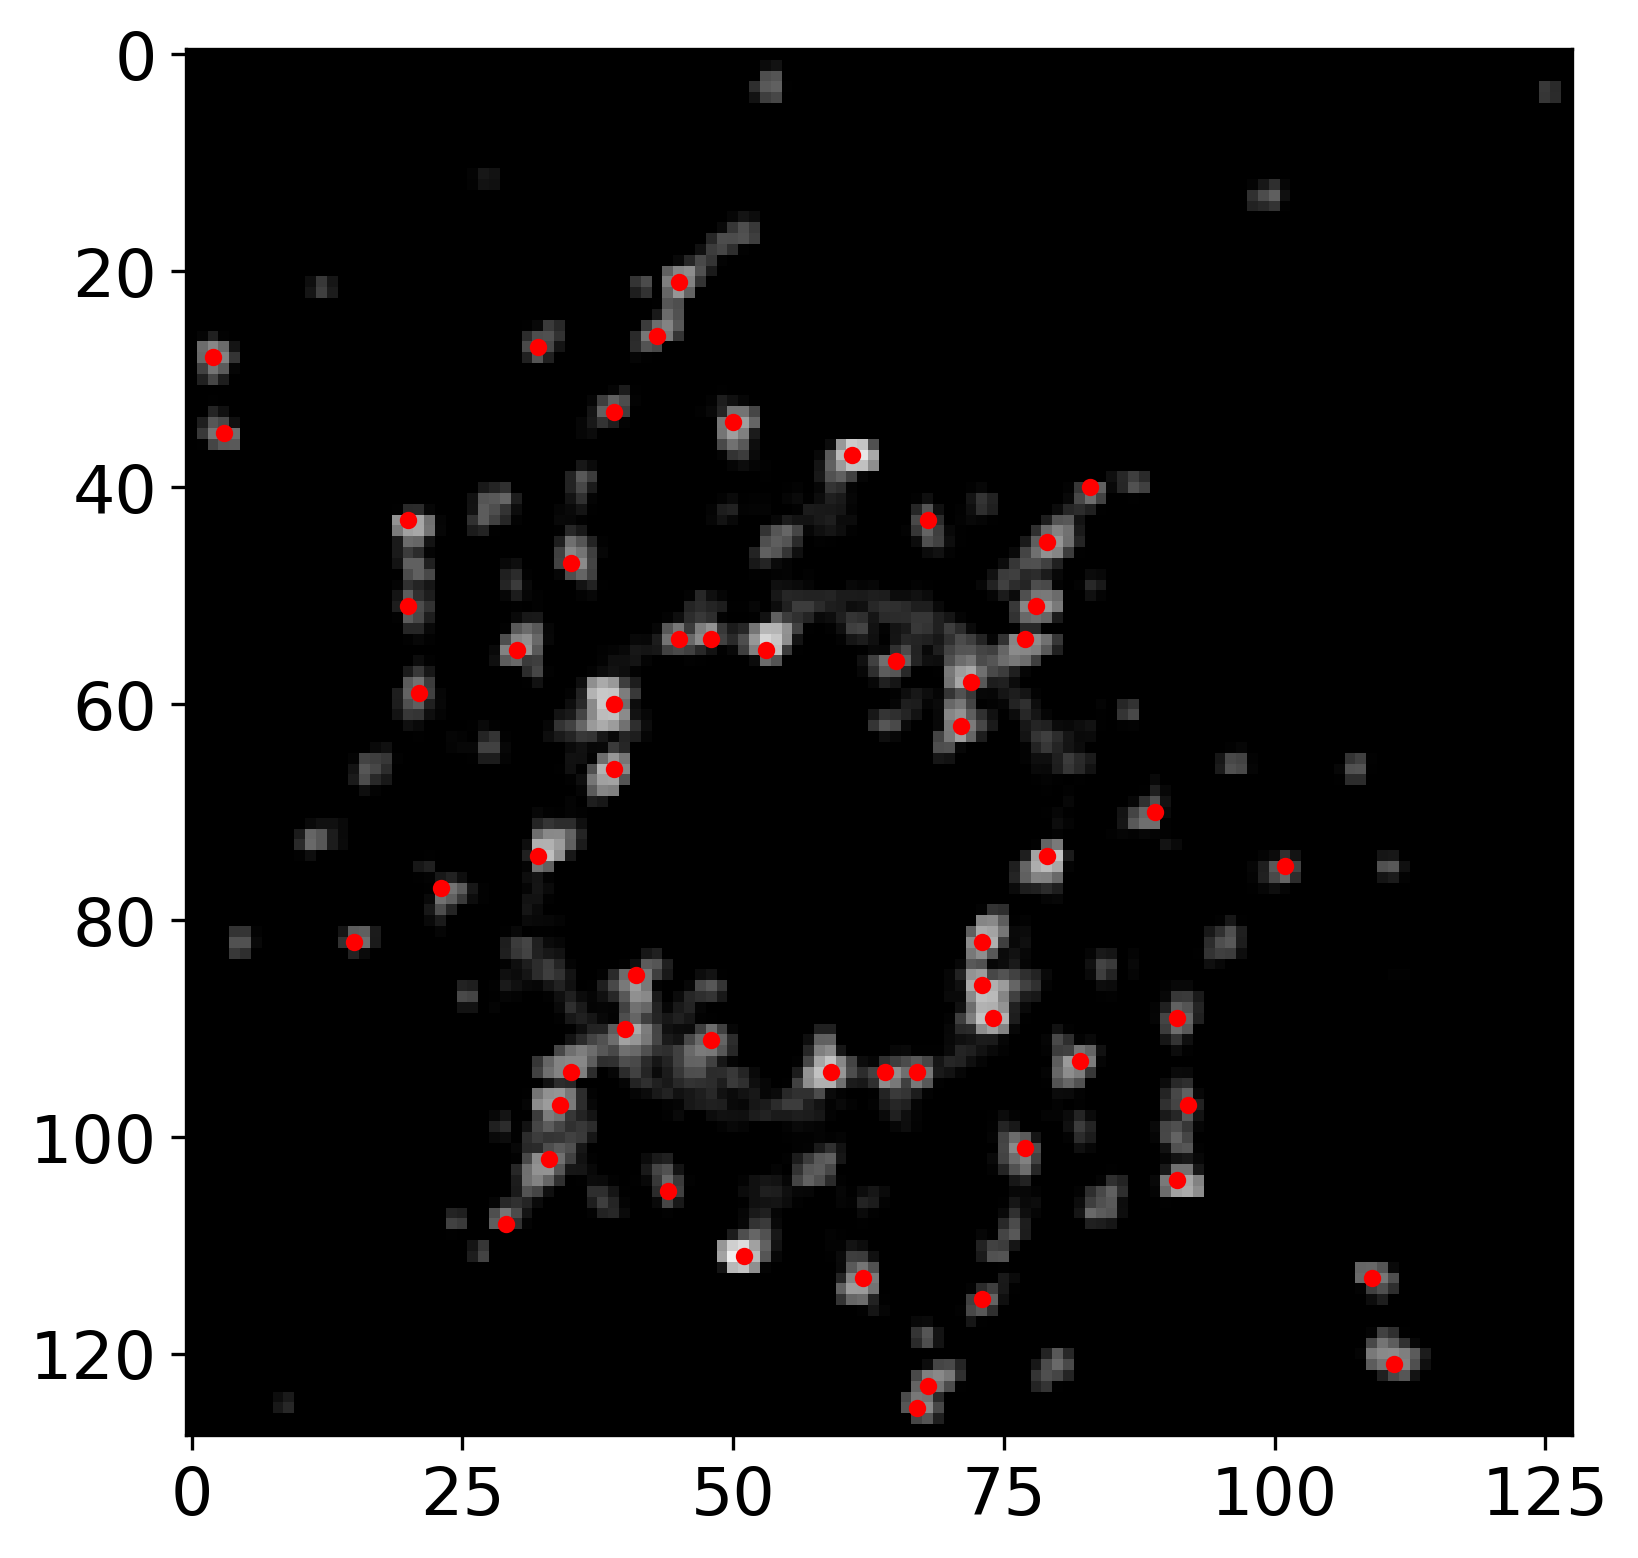

In [27]:
plt.imshow(np.log(bvm_raw+1), cmap='gray')
for i in range(len(gx)):
    Qx, Qy = int(gx[i]), int(gy[i])
    plt.scatter(Qy, Qx, c='r', s=10)

# Obtain bragg disk intensity/probability list of DPs

Total number of bragg disks is:58


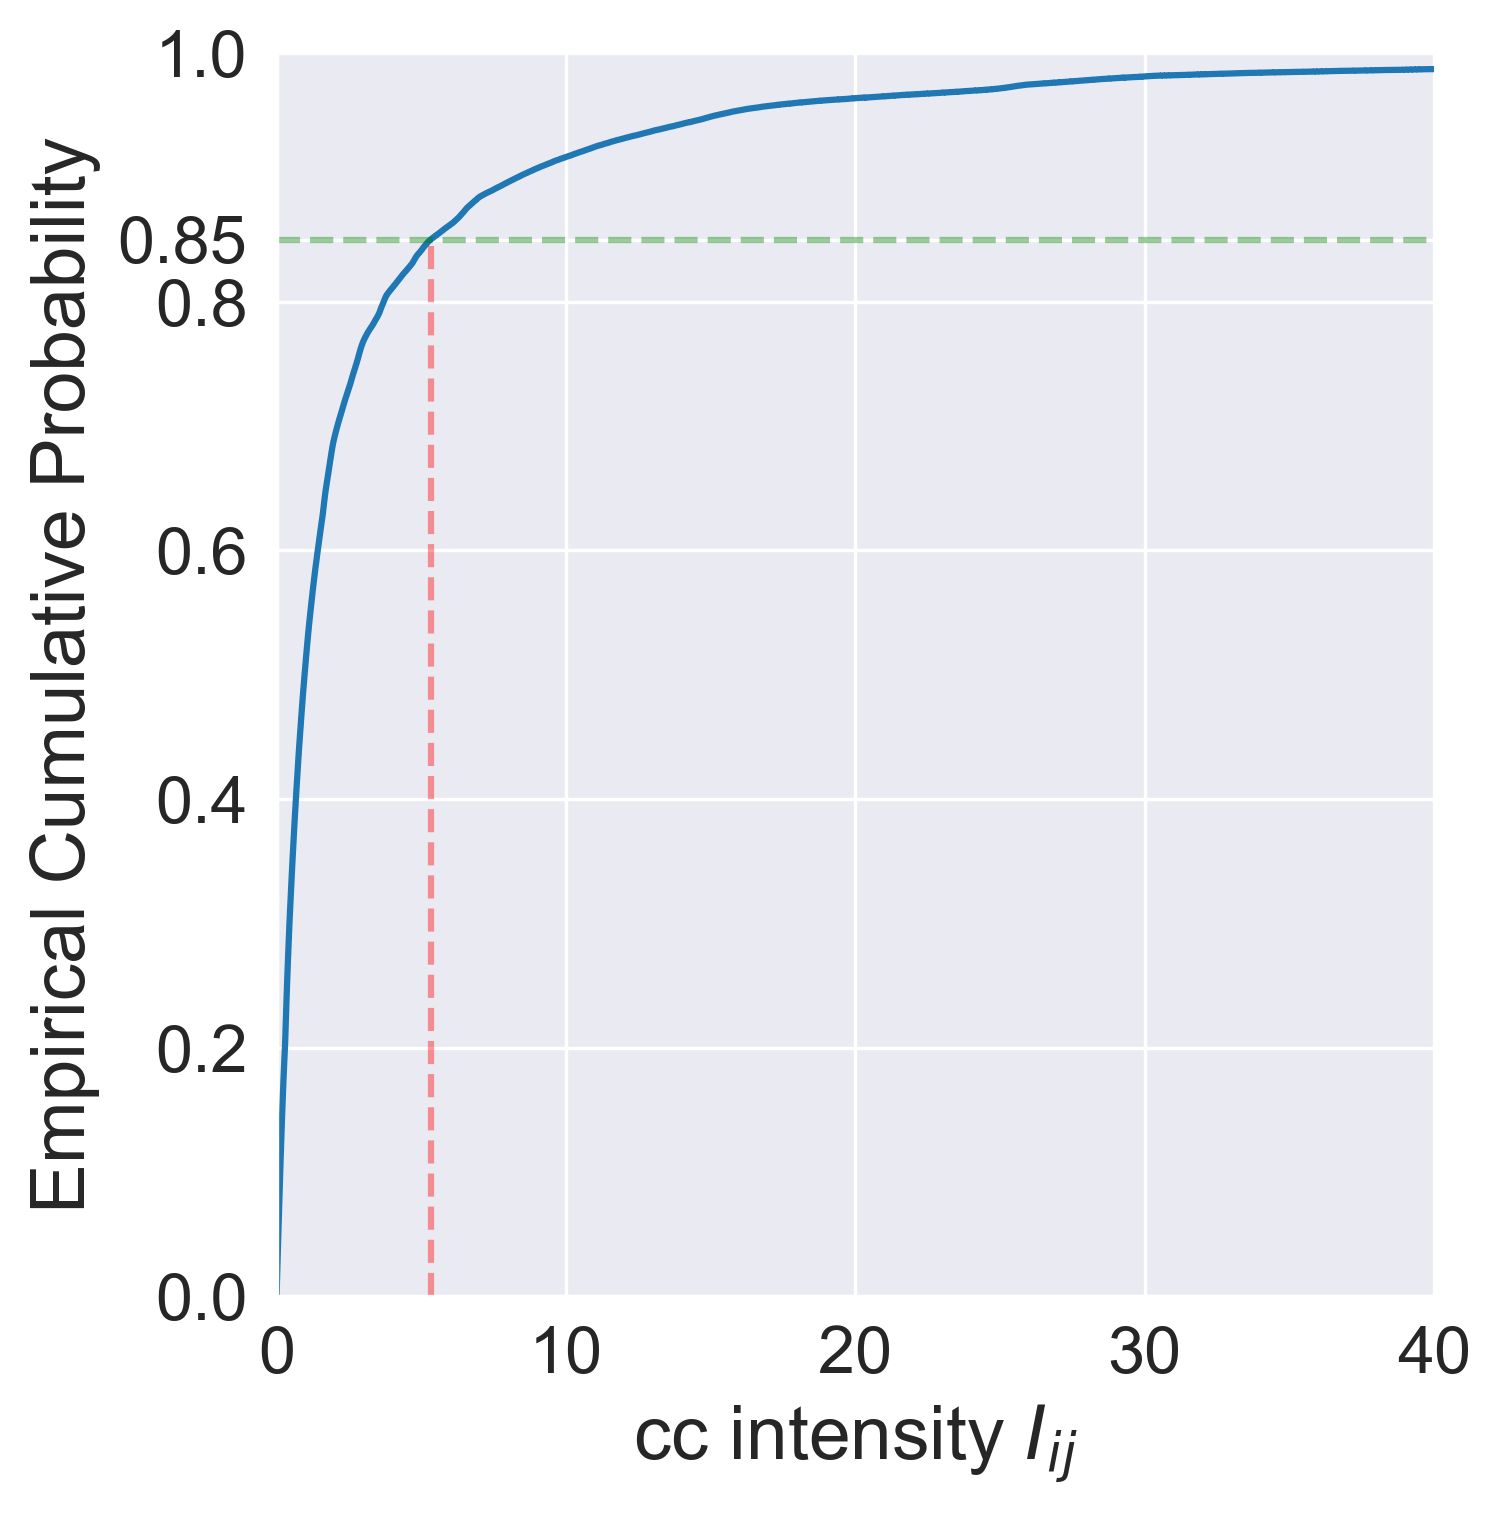

In [28]:
braggpeaks_intensity = create_intensity(braggpeaks_raw, datacube_symmetrize, gx, gy, probe_kernel_FT)
I_0 = find_I0(braggpeaks_intensity)
braggpeaks_intensity = np.minimum(braggpeaks_intensity, I_0)

In [29]:
braggpeaks_intensity = np.log(braggpeaks_intensity + 1)
braggpeaks_prob = np.zeros(braggpeaks_intensity.shape)
for i in range(braggpeaks_prob.shape[0]):
    for j in range(braggpeaks_prob.shape[1]):
        braggpeaks_prob[i][j] = braggpeaks_intensity[i][j] / max(braggpeaks_intensity[i][j])

In [30]:
#find beta
beta = find_beta(datacube_symmetrize, braggpeaks_prob, particle_labels)

In [31]:
print(I_0, beta)

5.326522132585589 0.006196712085335


# GMM clustering

33


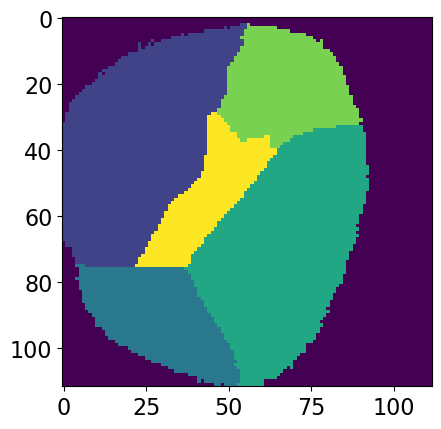

In [32]:
#GMM segmentation
X = braggpeaks_prob[particle_labels == 1]
real_pos = np.array(np.where(particle_labels == 1)).T # real space position (x,y)
alpha=beta
X = np.hstack((real_pos,alpha*X)) # Incorporate spatial proximity in this way.
n_components = 5
### "covariance_type" has a huge difference on the segmentation results. Try to play around and figure out how it affects the clustering results
gm = GaussianMixture(n_components=n_components, random_state=0, reg_covar=1e-6, warm_start=True, covariance_type = 'diag').fit(X)
label = np.zeros((particle_labels.shape))
label[np.where(particle_labels == 1)] = gm.predict(X)+1
#prob = gm.predict_proba(X)
print(gm.n_iter_)
plt.style.use('default')
fig = plt.figure(figsize=(6.4, 4.8))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 300
plt.imshow(label)

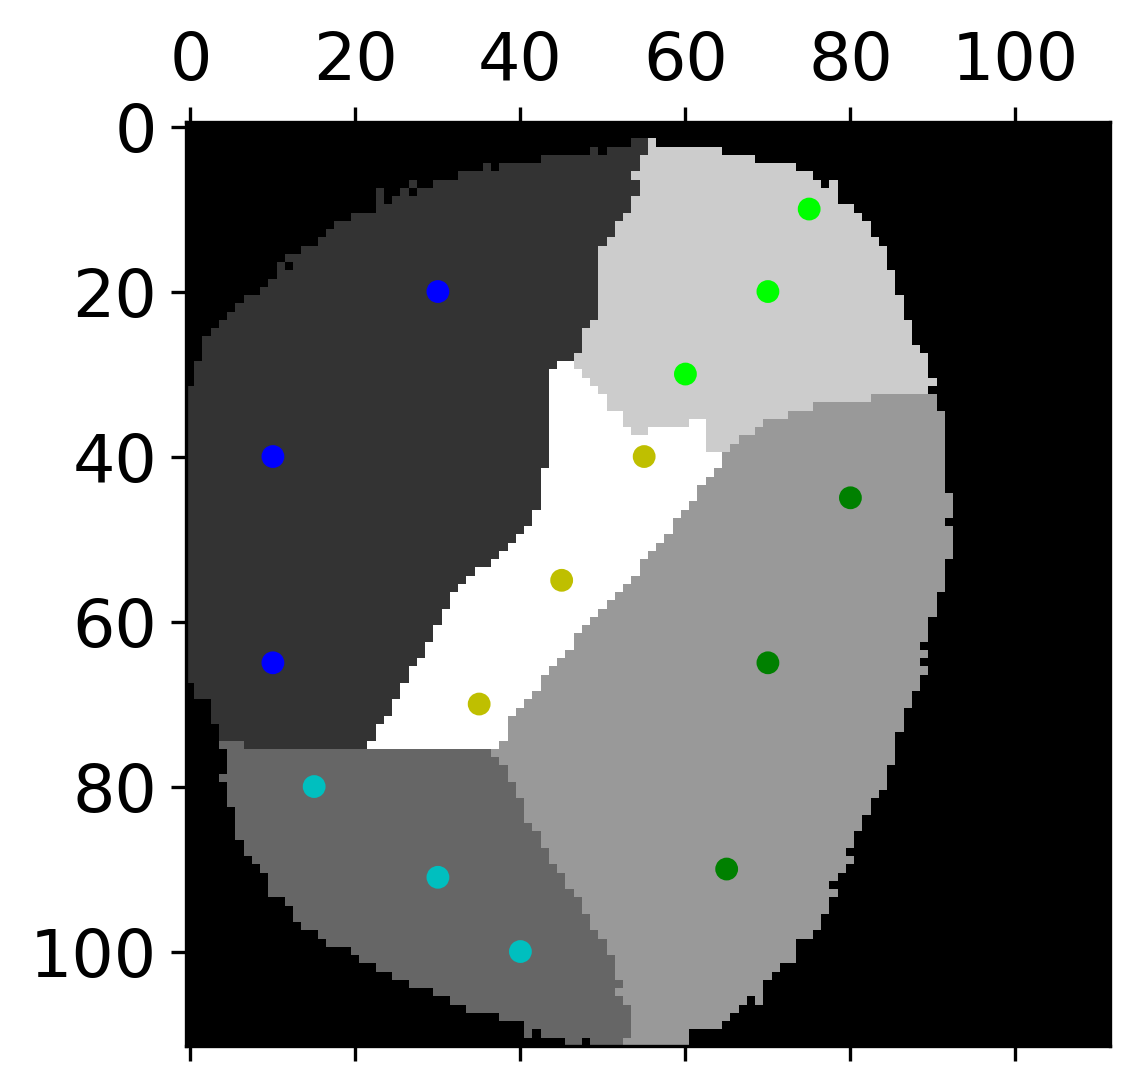

In [33]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.dpi': 300})
rxs = 20,40,65, 80,91,100, 45,65,90, 10,20,30, 40,55,70 
rys = 30,10,10, 15,30,40, 80,70,65, 75,70,60, 55,45,35 
colors=['b','b','b', 'c','c','c',
        'g','g','g', 'lime','lime','lime', 'y','y','y']
#rxs = 15,35,50, 65,85,105, 5,25,40, 55,70,90, 50,70,95,    
#rys = 55,60,40, 50,55,60, 20,20,20, 20,20,15, 80,90,90,    
#colors=['m','m','m', 'b','b','b', 'c','c','c',
#        'g','g','g', 'y','y','y']
#rxs = 25,40,60, 45,60,70, 35,45,55, 57,65,72    
#rys = 40,55,65, 20,27,40, 22,30,40, 47,55,58    
#colors=['m','m','m', 'b','b','b', 'c','c','c',
#        'y','y','y']
py4DSTEM.visualize.show_points(label,x=rxs,y=rys,pointcolor=colors,figsize=(4,4),scale=20)

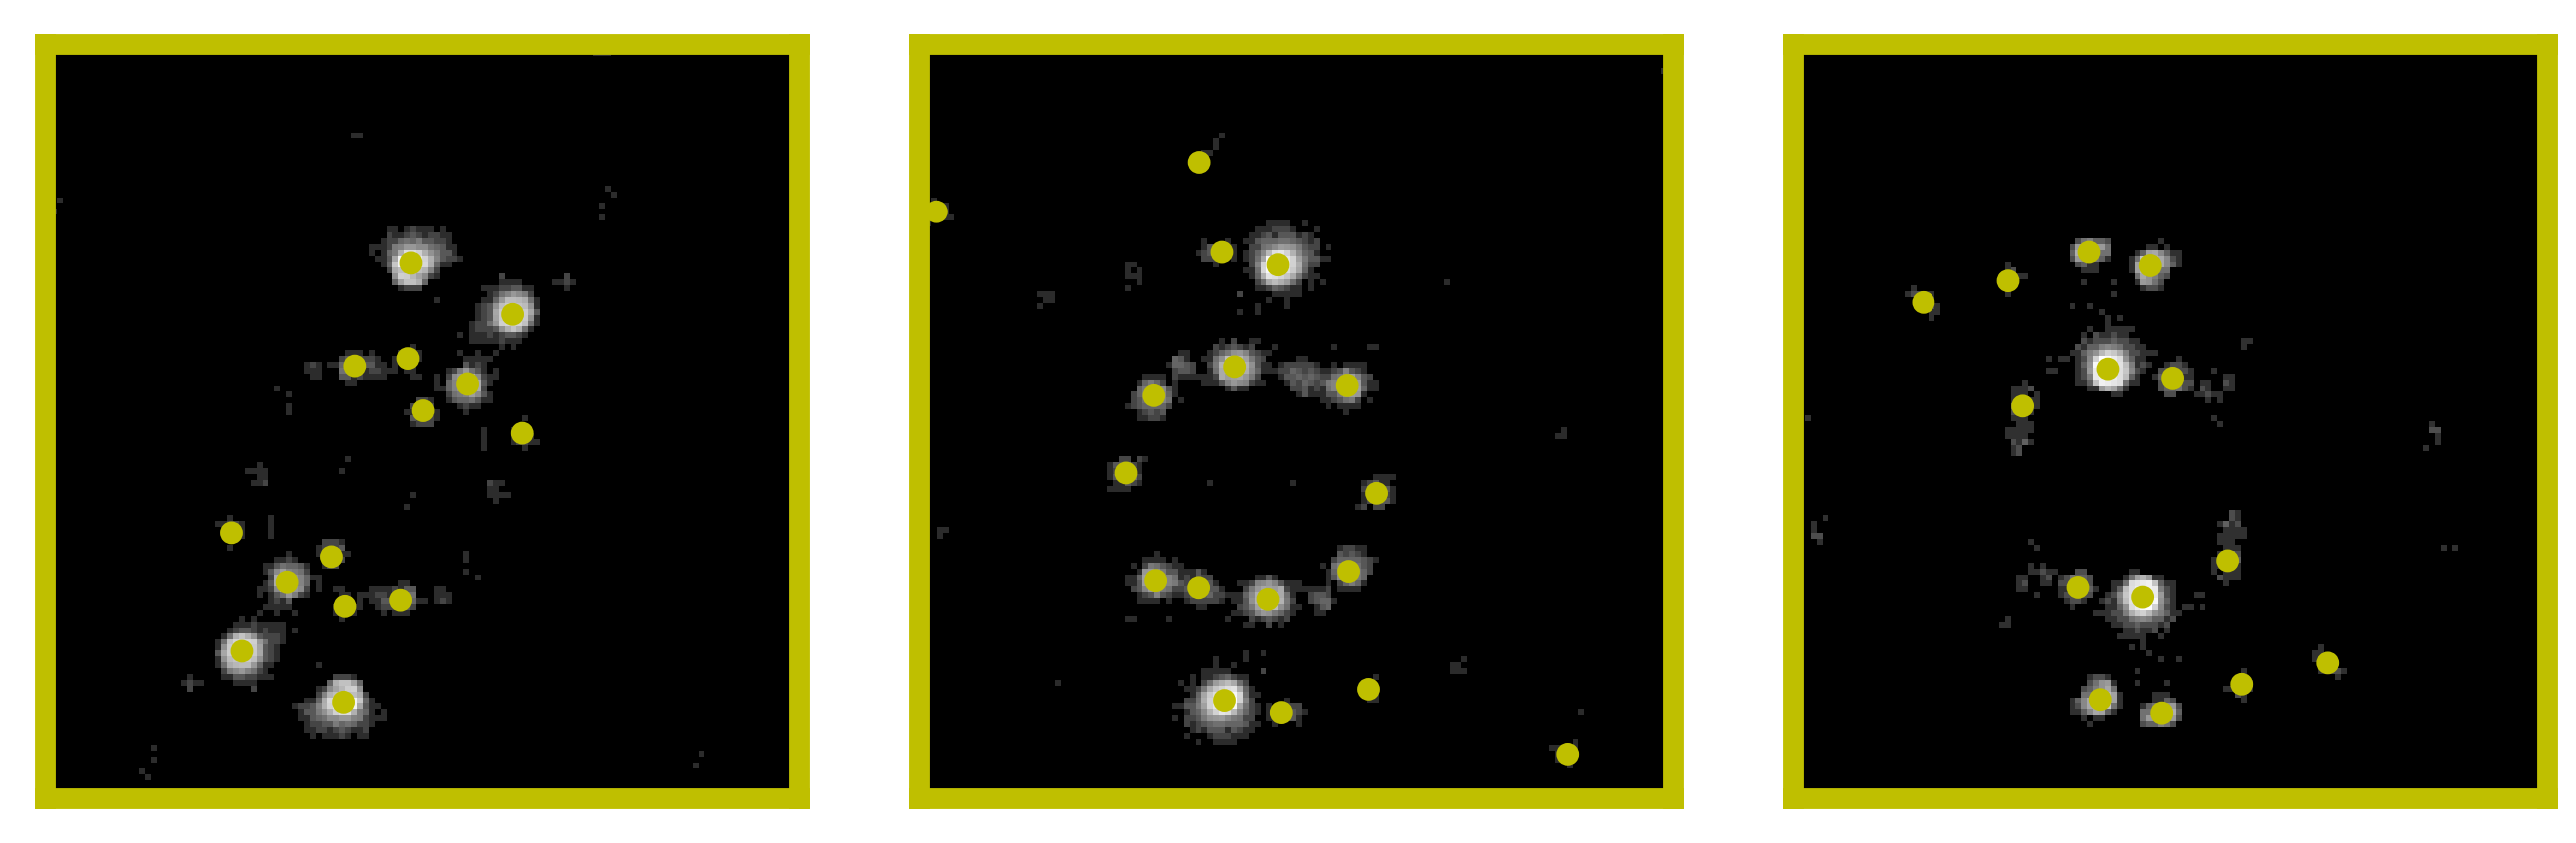

In [34]:
# cluster 1
k=4
dp1=datacube_symmetrize.data[rxs[0+k*3],rys[0+k*3],:,:]
dp2=datacube_symmetrize.data[rxs[1+k*3],rys[1+k*3],:,:]
dp3=datacube_symmetrize.data[rxs[2+k*3],rys[2+k*3],:,:]
py4DSTEM.visualize.show_image_grid(lambda i:[dp1,dp2,dp3][i],H=1,W=3,axsize=(3,3),
                                   scaling='log',
                                   scale = 20,
                                   get_bordercolor=lambda i:colors[i+k*3],
                                   get_x=lambda i:braggpeaks_raw.pointlists[rxs[i+k*3]][rys[i+k*3]].data['qx'],
                                   get_y=lambda i:braggpeaks_raw.pointlists[rxs[i+k*3]][rys[i+k*3]].data['qy'],
                                   get_pointcolors=lambda i:colors[i+k*3],
                                   )

# Probability plots

[37 23] [22 66]


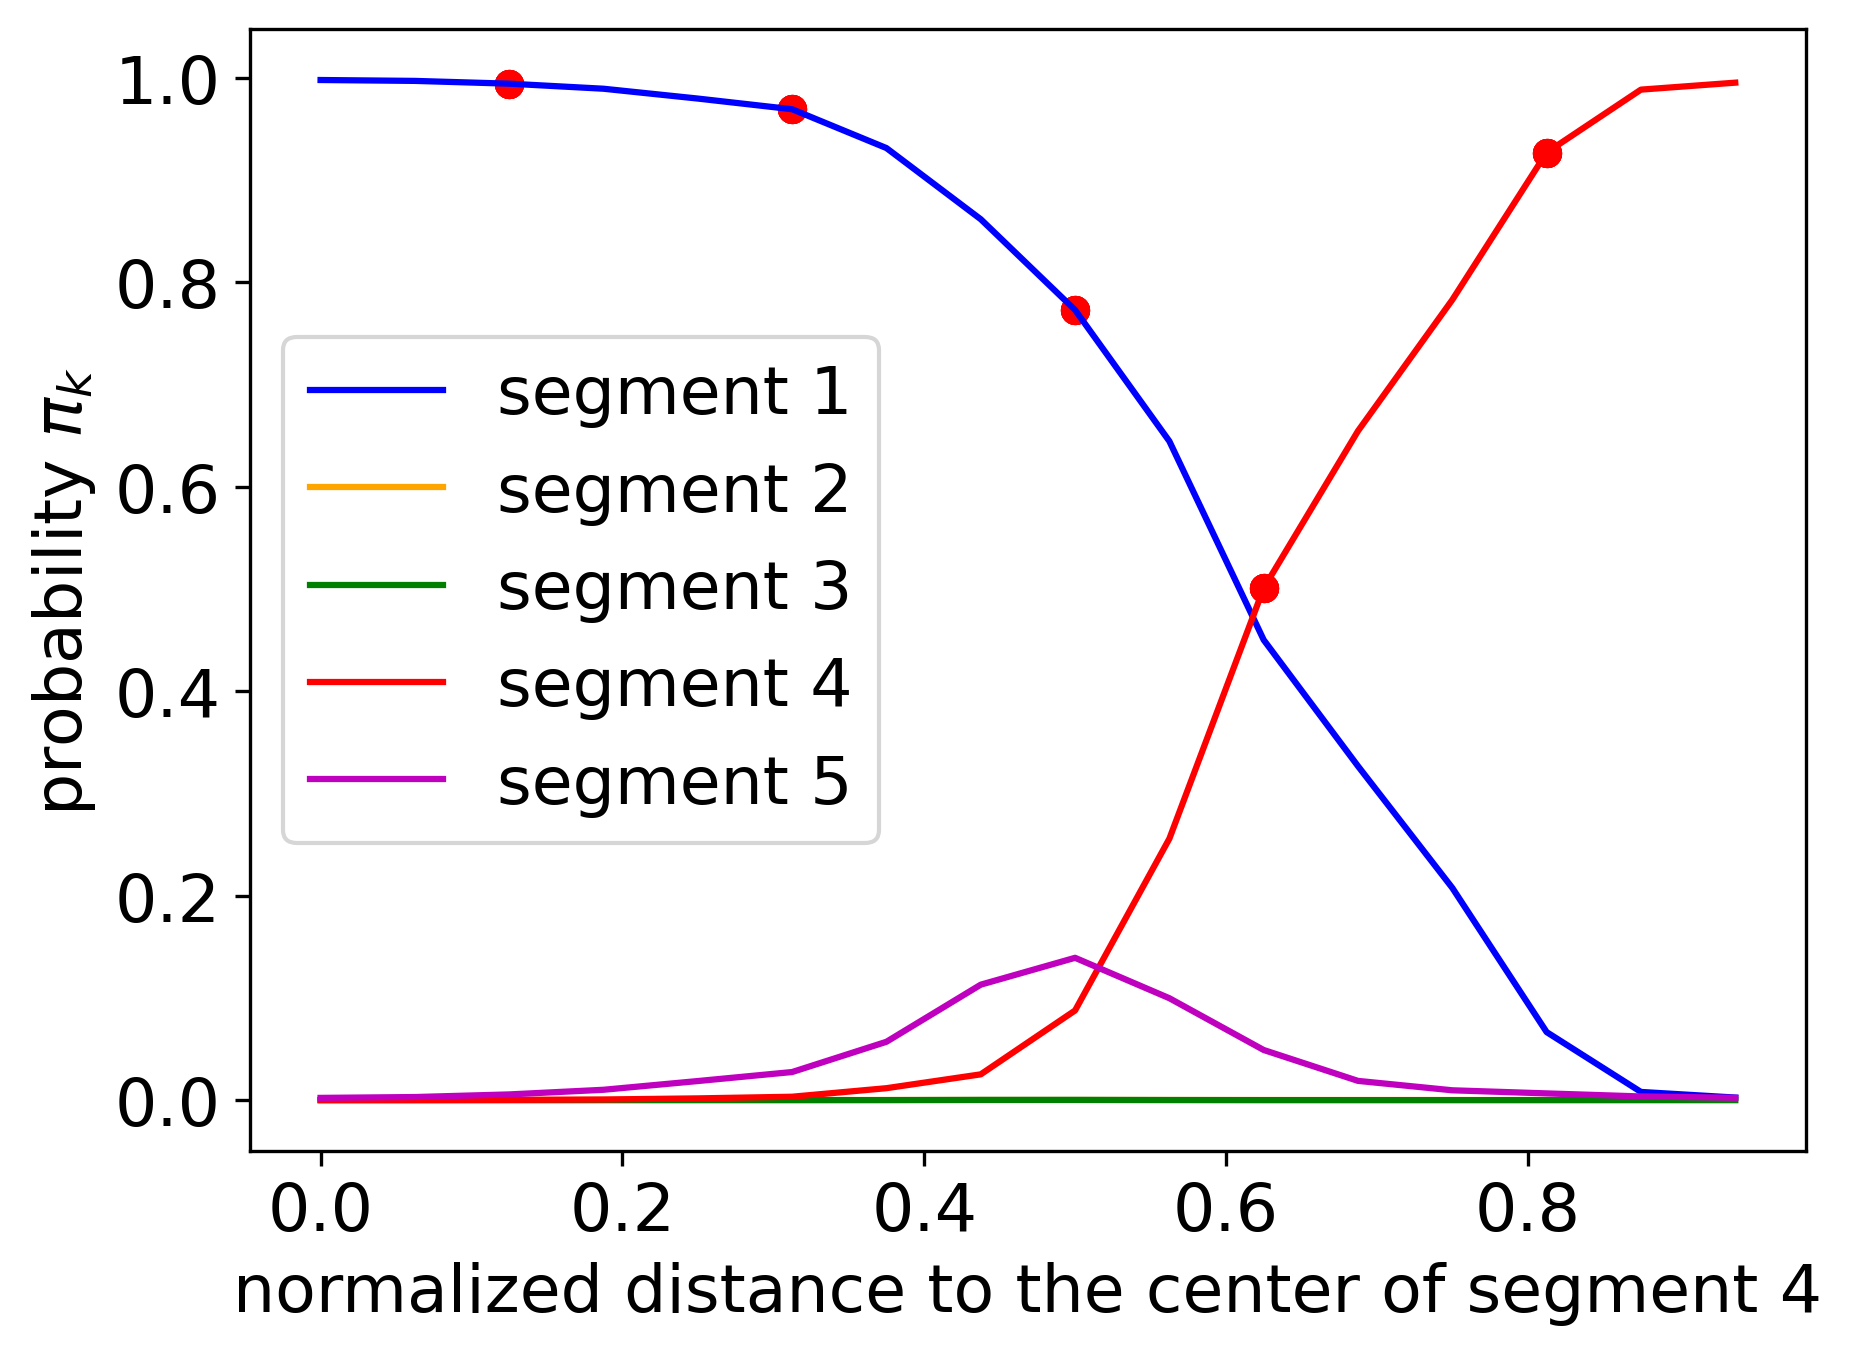

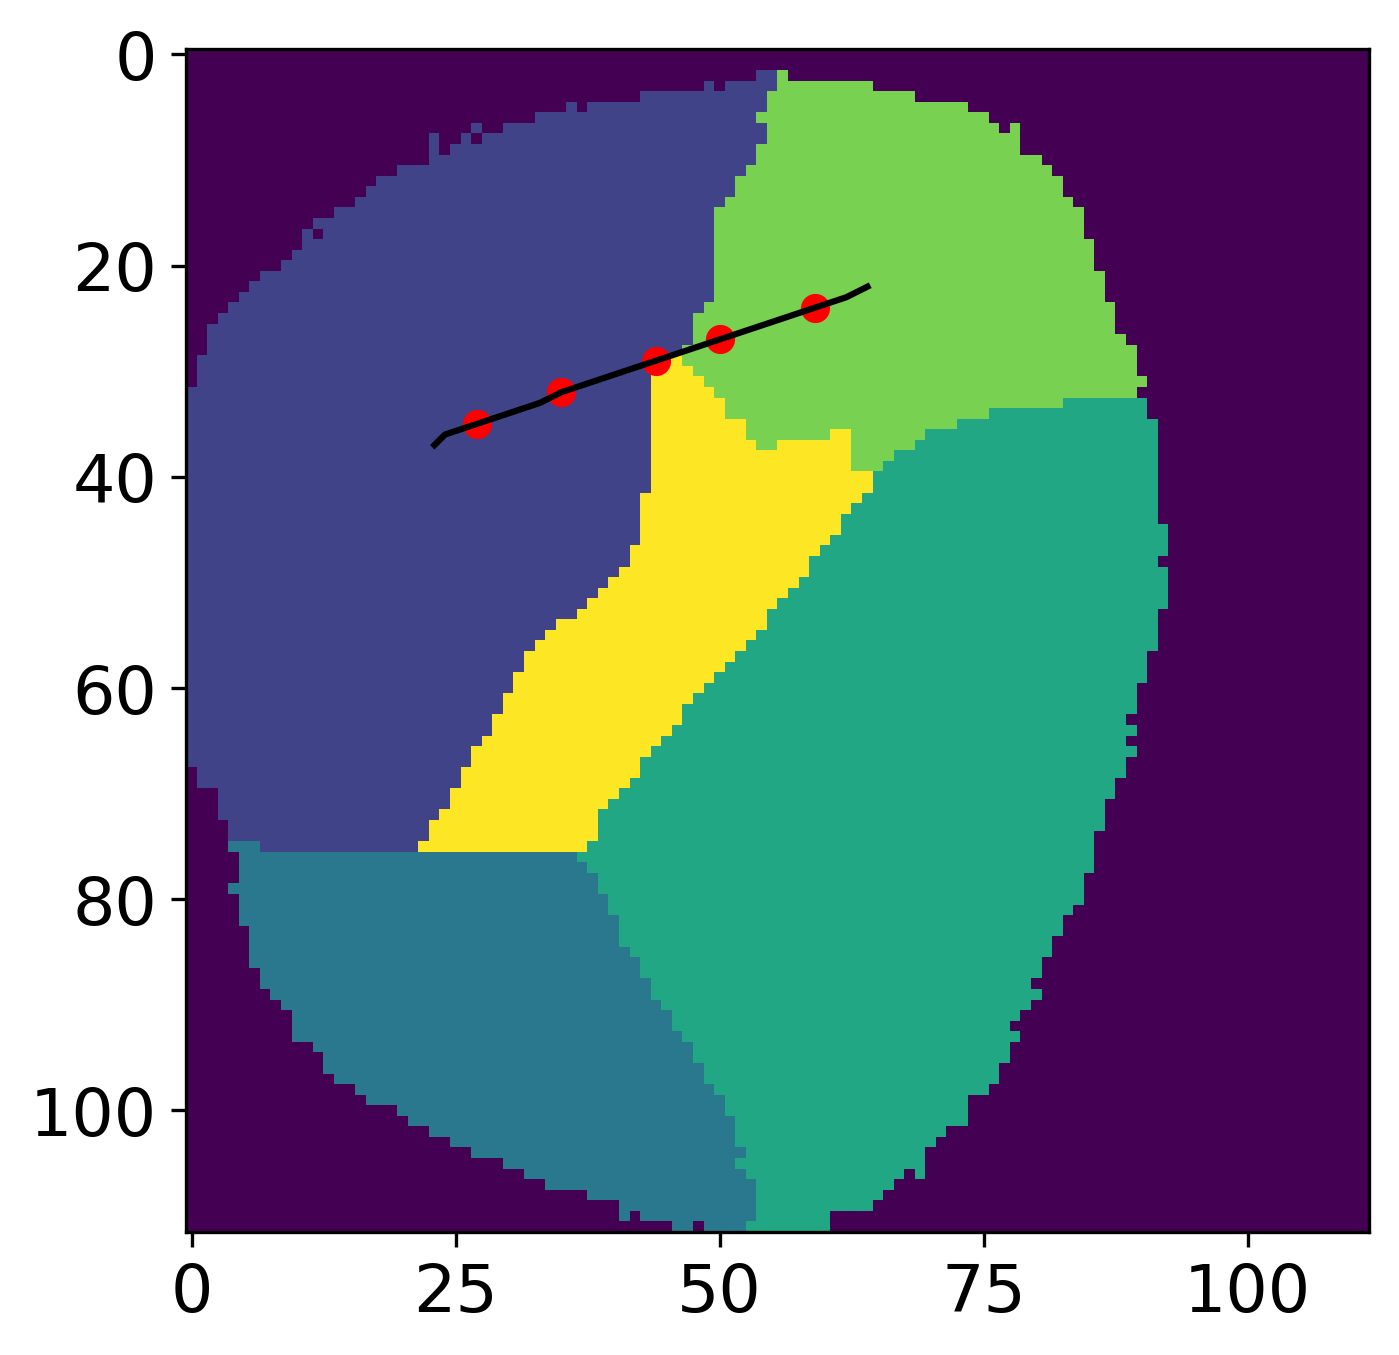

In [35]:
prob = gm.predict_proba(X)

cov_ls = []
for i in range(n_components):
    diff = X - gm.means_[i]
    cov = diff.T @ (prob[:, i][:, np.newaxis] * diff) / prob[:, i].sum()
    #a = np.diag(cov)
    #a1, a2 = np.mean(a[:2]), np.mean(a[2:])
    #temp = np.concatenate((np.repeat(a1, 2), np.repeat(a2, X.shape[1]-2)))
    cov_ls.append(cov)
    
cluster1=0
cluster2=3
X_plot, prob, middle_plot, middle_prob = plot_transit_prob(gm, cov_ls, braggpeaks_prob, alpha, 
                                        label, cluster1, cluster2, 100)

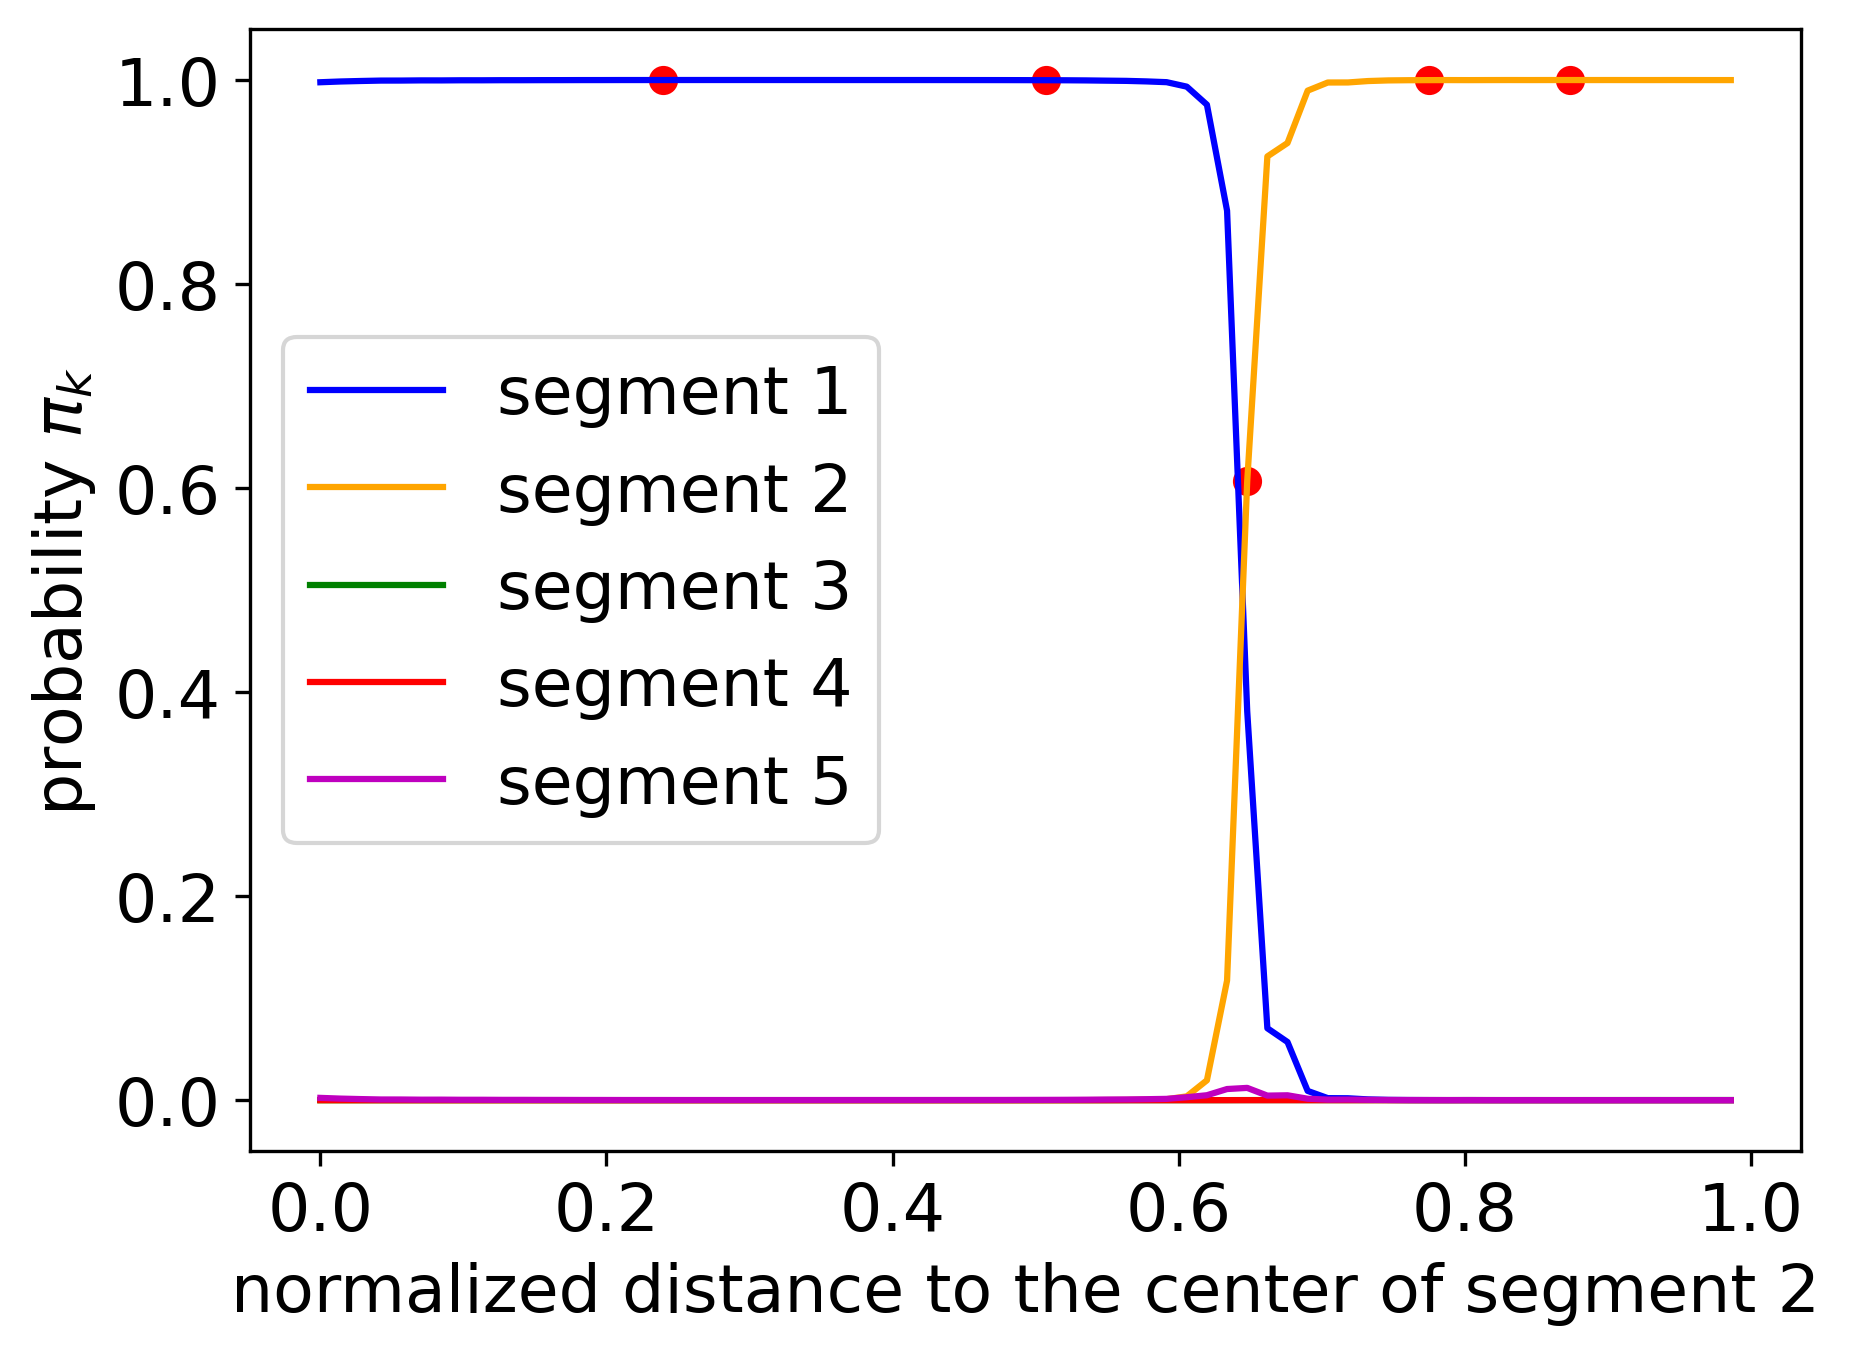

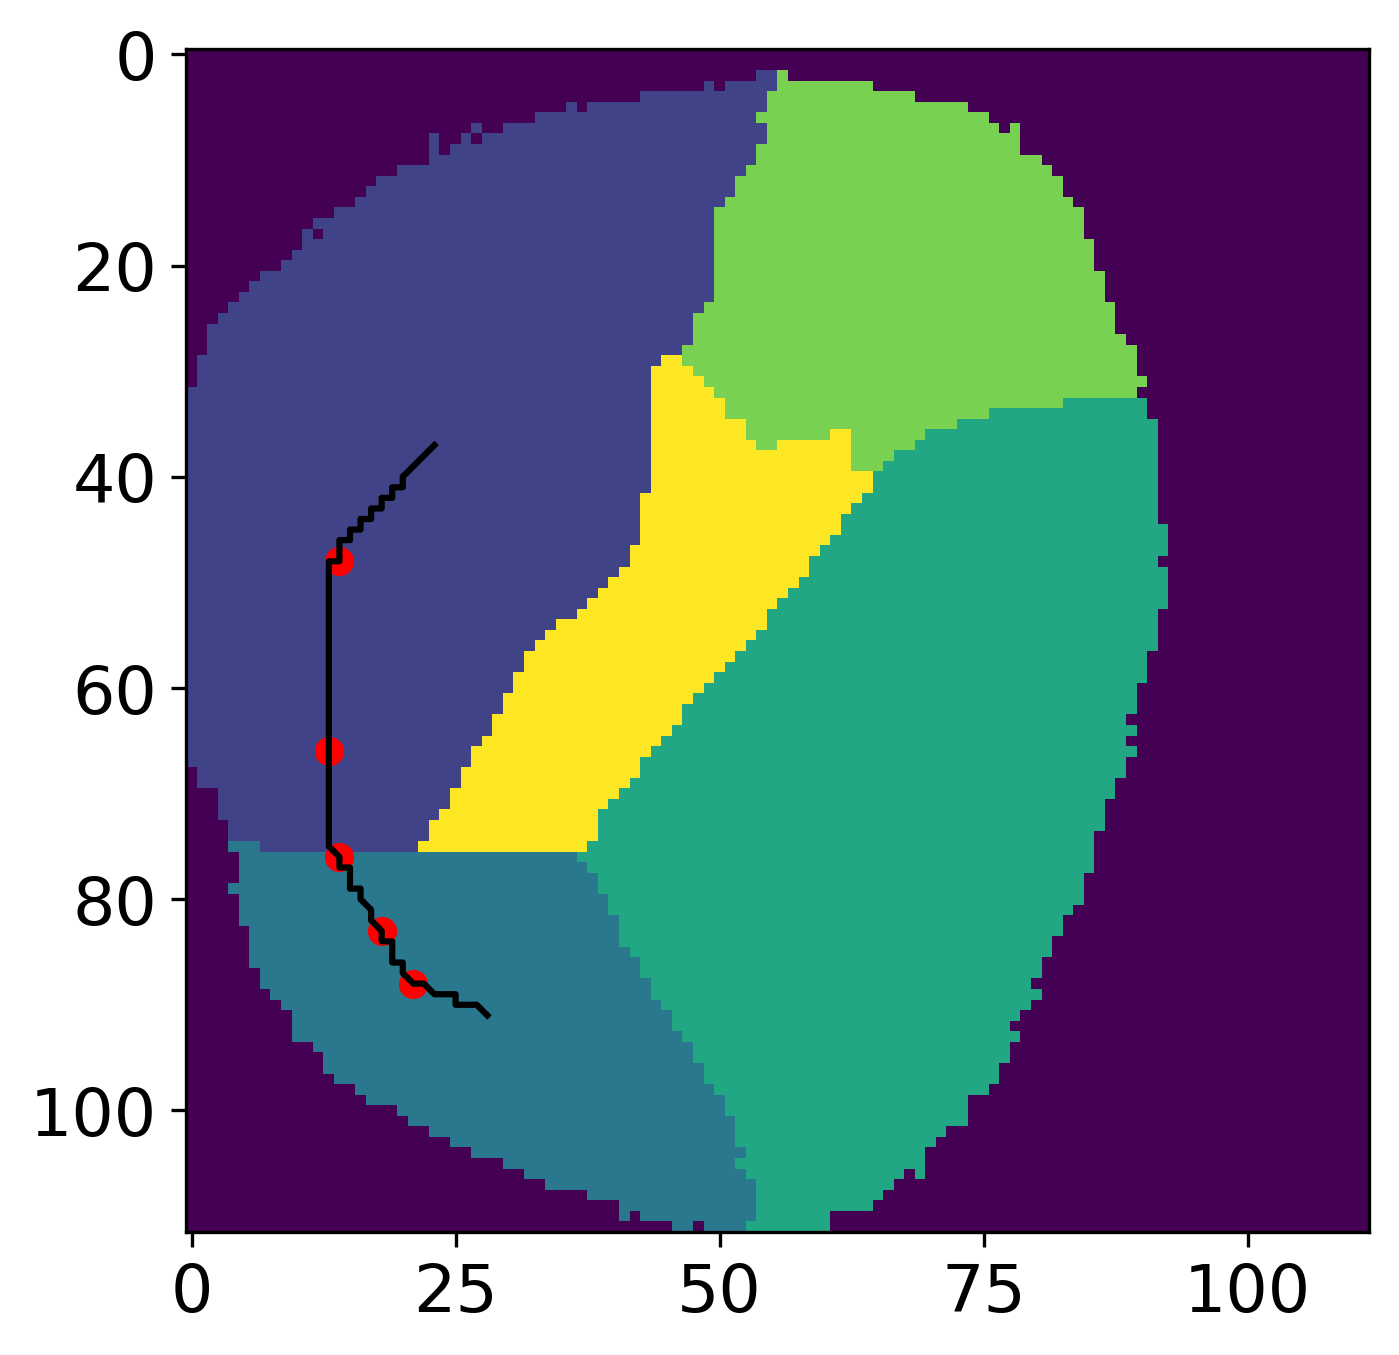

In [36]:
cluster1, cluster2 = 0, 1
X_plot, prob, middle_plot, middle_prob = plot_transit_prob_interpolate(gm, cov_ls, braggpeaks_prob, 
                                        alpha, label, cluster1=cluster1, cluster2=cluster2, 
                                        n=20, middle_points = [[48,14],[66,13],[76,14],[83,18],[88,21]])

# Transparency plot

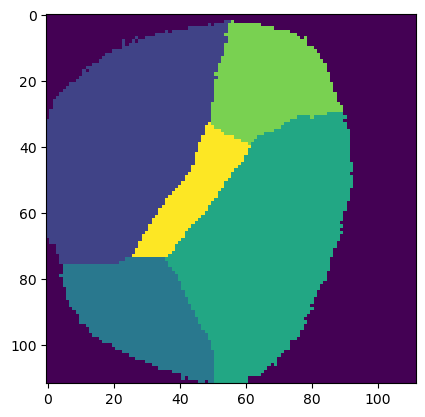

In [37]:
X_new = braggpeaks_prob[particle_labels == 1]
#X_new, _ = scipy.stats.boxcox(X_new)
real_pos = np.array(np.where(particle_labels == 1)).T # real space position (x,y)

alpha=beta
X_new = np.hstack((real_pos, alpha*X_new)) 
real_pos = np.array(np.where(particle_labels == 1)).T # real space position (x,y)
prob = gm.predict_proba(X)

n_samples = X.shape[0]
n_features = X.shape[1]
#n_components, n_features = 6, 62
'''
means = np.empty((6, 62))
for i in range(6):
    real = np.array(np.where(label == i+1)).T
    reci = np.log(braggpeaks_prob[label == i+1] + 1e-6)
    x_i = np.hstack((real, alpha * reci))
    means[i, :] = np.mean(x_i, axis=0)
    
cov_ls = []
for i in range(n_components):
    diff = X - means[i]
    cov = diff.T @ (prob[:, i][:, np.newaxis] * diff) / prob[:, i].sum()
    cov_ls.append(cov)
    
'''
#means = np.round(gm.means_[:, :2])
#means = means.astype(int)
#means = np.hstack((means, alpha * braggpeaks_prob[means[:, 0], means[:, 1]]))
means = gm.means_

precisions_chol = np.empty((n_components, n_features))  
precisions = np.empty((n_components, n_features))
for k, covariance in enumerate(cov_ls):  
    #cov = gm.covariances_[k]
    cov = np.diag(covariance) + 1e-5
    precisions_chol[k] = np.sqrt(1 / (cov))
    #precisions_chol[k] = np.sqrt(1 / cov)
    precisions[k] = 1 / cov

log_det = np.sum(np.log(precisions_chol), axis=1)

log_prob = np.empty((n_samples, n_components))
'''
for k, (mu, prec_chol) in enumerate(zip(means, precisions_chol)):
    y = (X_new-mu)*prec_chol
    y = y**2
    #y = np.maximum(y, -np.log( 2 * np.pi * (np.diag(cov_ls[k])+1e-5)) + np.log(1e-7))
    log_prob[:, k] = np.sum(y, axis=1)


log_prob = (
        np.sum((means**2 * precisions), 1) 
        - 2.0 * np.dot(X_new, (means * precisions).T)
        + np.dot(X_new**2, precisions.T)
    )
'''
for k, (mean, prec_chol) in enumerate(zip(means, precisions_chol)):
    y = (X_new-mean) * prec_chol
    y = y**2
    #print(np.max(y))
    #y[:, 2:] = np.minimum(y[:, 2:], -np.log(2 * np.pi / precisions[k][2:])- 2*np.log(1e2))
    #y = np.minimum(y, -np.log(2 * np.pi / precisions[k]) - 2*np.log(1e1))
    log_prob[:, k] = np.sum(y, axis=1)

prob_new = -0.5 * (n_features * np.log(2 * np.pi) + log_prob) + log_det[np.newaxis, :]

weighted_log_prob = 0.5*prob_new + np.log(gm.weights_)
log_prob_norm = np.log(np.sum(np.exp(weighted_log_prob), axis=1))
log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]

label_new = np.zeros((particle_labels.shape))
label_new[np.where(particle_labels == 1)] = np.argmax(log_resp, axis=1)+1
plt.style.use('default')
plt.imshow(label_new)
plt.show()
plt.close()

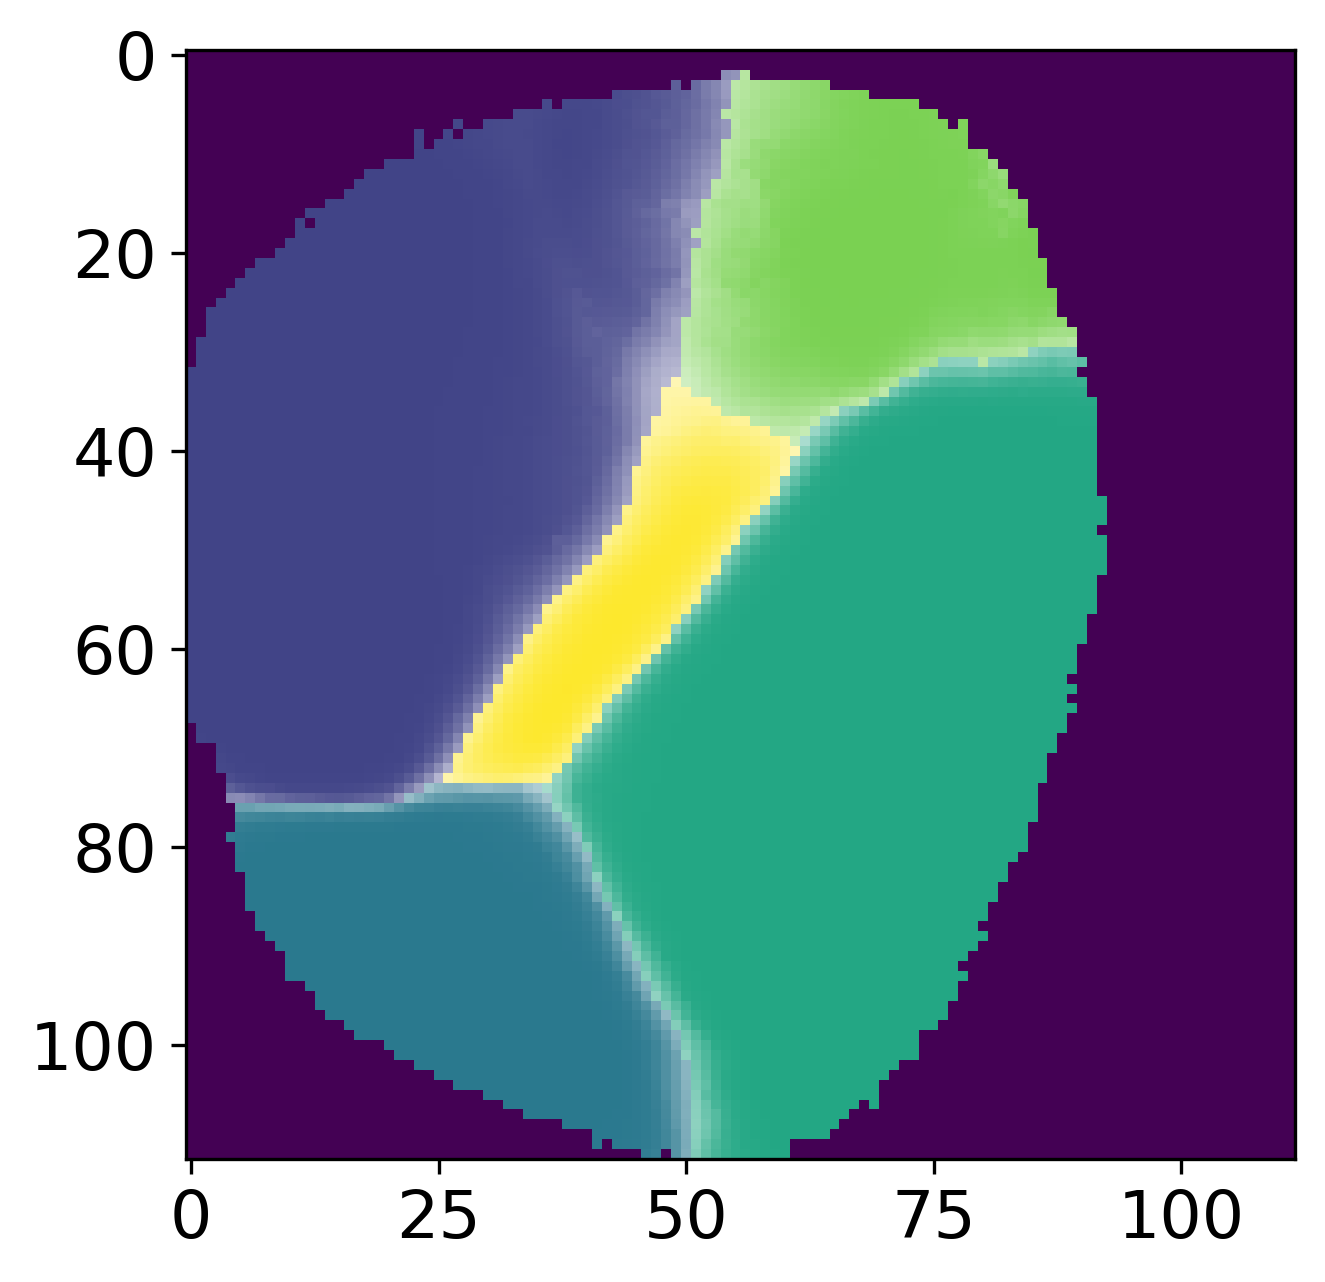

In [38]:
### get the highest probability for plotting purpose (in imshow, 'alpha' represents the transparency of the color)
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.dpi': 300})
cluster_prob = np.ones(particle_labels.shape)
cluster_prob[particle_labels == 1] = np.max(np.exp(log_resp), axis = 1)
cluster_prob[particle_labels == 0] = 1
plt.imshow(label_new, alpha=cluster_prob)

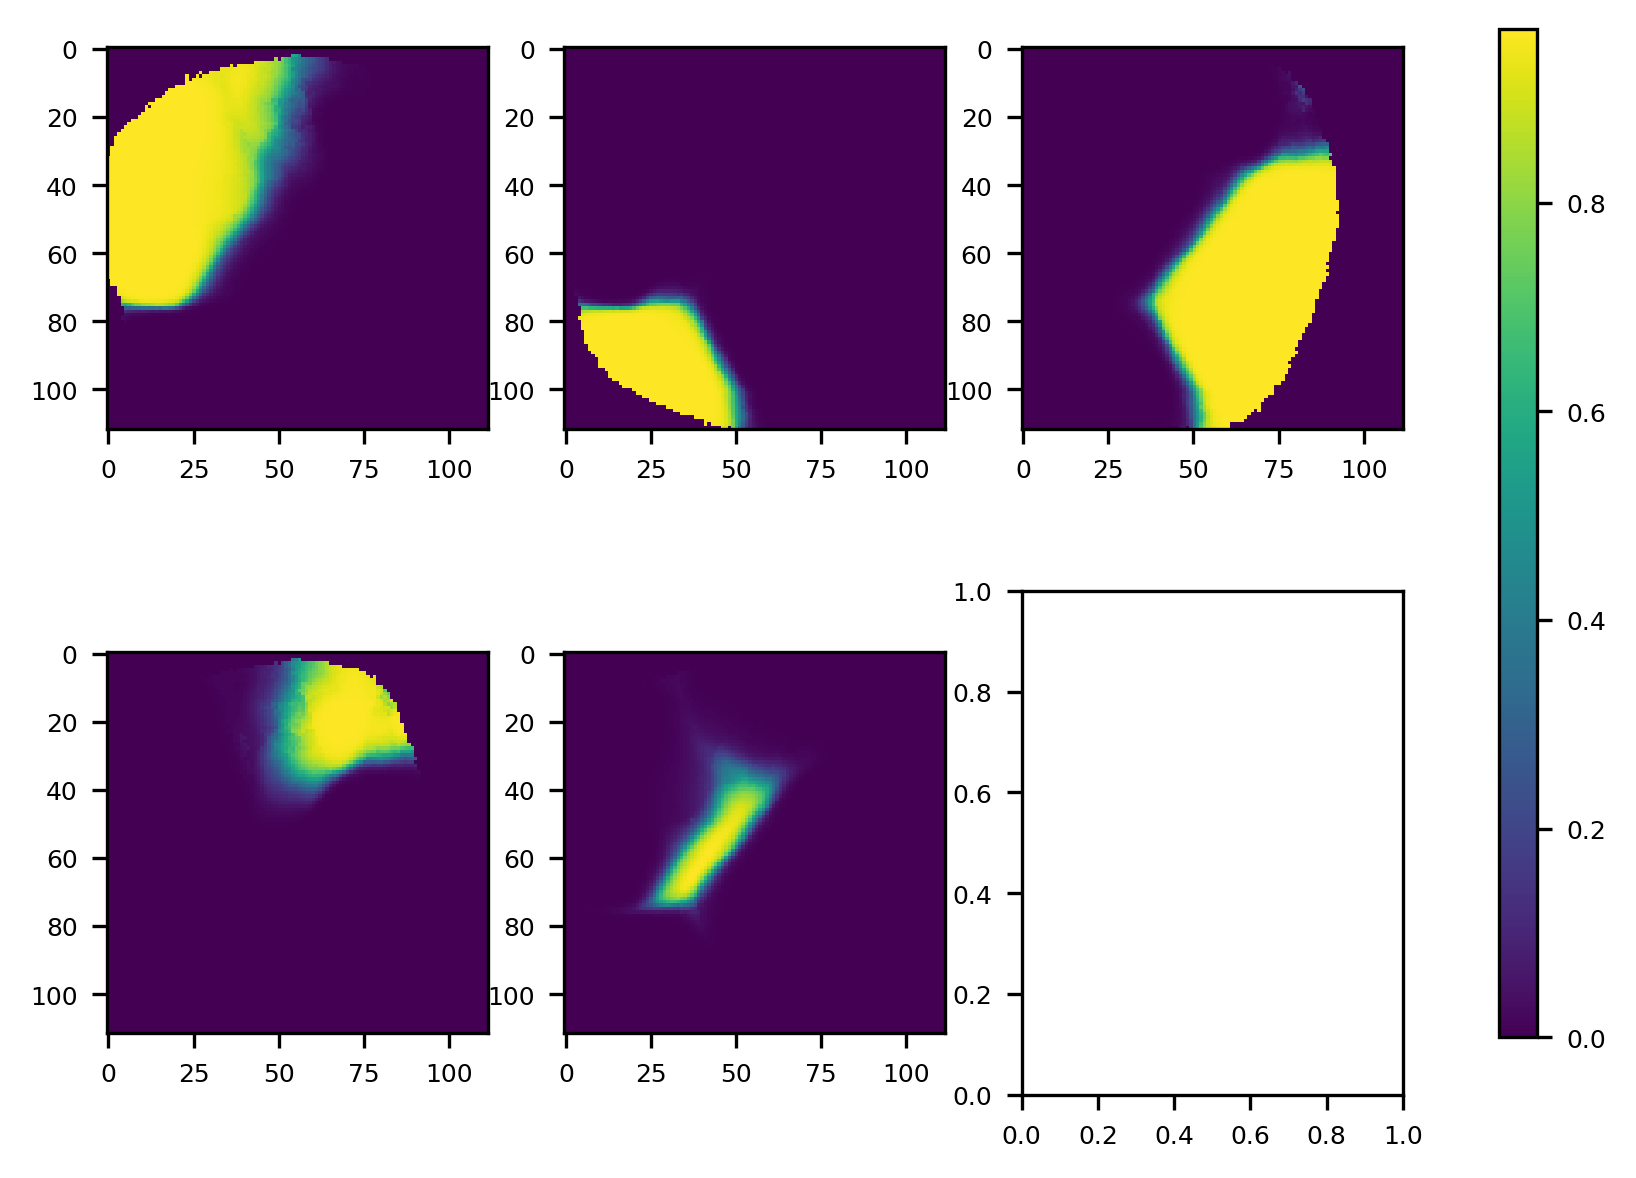

In [39]:
plt.rcParams.update({'font.size': 6})
plt.rcParams.update({'figure.dpi': 300})

fig, ax = plt.subplots(nrows=2, ncols=3)

for i in range(5):
    row, col = i//3, i%3
    trans_prob = np.ones(particle_labels.shape)
    trans_prob[particle_labels == 1] = np.exp(log_resp)[:, i]
    trans_prob[particle_labels == 0] = 0
    im = ax[row][col].imshow(trans_prob)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()